**this is my first dataset and my first competition , I would be immensely grateful if you could take a moment to review my notebook and share any feedback or advice you may have. Your insights and suggestions would be incredibly valuable to me as I continue to improve my data science skills.** ♥♥

**some articles i read to understand  a couple of features  : https://my.clevelandclinic.org/health/diseases/22795-hypovolemic-shock

https://minivetguide.com/pcvtp-how-to-get-the-most-out-of-this-simple-test/

https://aaep.org/sites/default/files/issues/proceedings-11proceedings-318.PDF

https://horse-canada.com/magazine/health/shock-when-the-body-shuts-down/#:~:text=Horses%20suffer%20shock%20for%20a,fear%2C%20blood%20loss%20and%20dehydration.**

![Image](https://images.inc.com/uploaded_files/image/1920x1080/getty_492499085_347227.jpg)

# imports

In [22]:
from sklearn.metrics import get_scorer_names
import optuna 
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve

#############################
import lightgbm as lgb
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
#################################
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest, chi2
import warnings
warnings.filterwarnings('ignore')
import missingno as msno

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif

# Data loading

In [23]:
trainx = pd.read_csv('../input/playground-series-s3e22/train.csv')
test = pd.read_csv('../input/playground-series-s3e22/test.csv')
original = pd.read_csv('../input/horse-survival-dataset/horse.csv')
submission = pd.read_csv('../input/playground-series-s3e22/sample_submission.csv')

In [24]:
train = pd.concat([trainx, original], ignore_index=True)
train.drop_duplicates(inplace=True)
total = pd.concat([train, test], ignore_index=True)
target='outcome'

concatenating  the train dataset with the original dataset for later analysis to later check if it would positively affect the model performance ( update : it did )  

In [25]:
print('The dimension of the total dataset is:', total.shape)
print('The dimension of the test dataset is:', test.shape)
print('The dimension of the original train dataset is:', original.shape)
print('The dimension of the train dataset is:', trainx.shape)

The dimension of the total dataset is: (2358, 29)
The dimension of the test dataset is: (824, 28)
The dimension of the original train dataset is: (299, 28)
The dimension of the train dataset is: (1235, 29)


# EDA and preprocessing

0             died
2            lived
3            lived
6       euthanized
7             died
           ...    
1525          died
1526          died
1527    euthanized
1531          died
1532         lived
Name: outcome, Length: 827, dtype: object


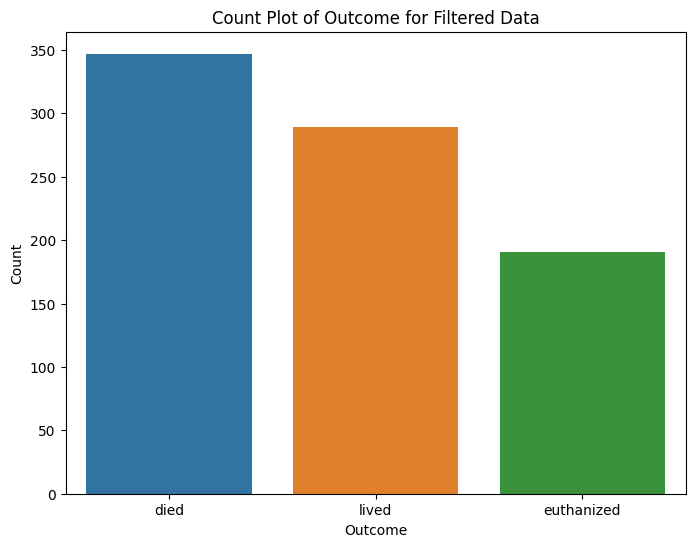

In [26]:

filtered_data = train[(train['peripheral_pulse'] =='reduced') ]


print(filtered_data['outcome'])
plt.figure(figsize=(8, 6))  
sns.countplot(data=filtered_data, x='outcome')


plt.xlabel('Outcome')
plt.ylabel('Count')
plt.title('Count Plot of Outcome for Filtered Data')


plt.show()

In [27]:
total.drop('id',axis=1,inplace=True)


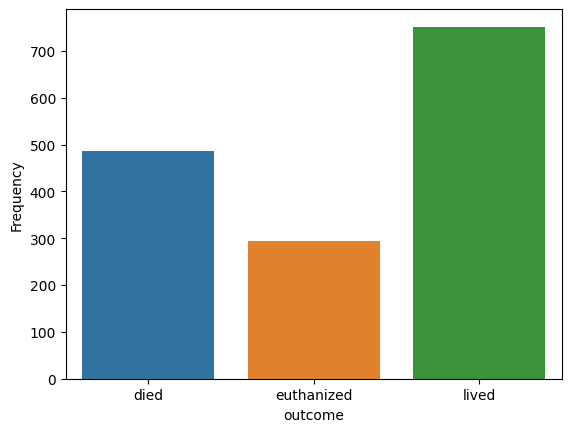

In [28]:
sns.countplot(data = total, x = 'outcome')
plt.ylabel('Frequency');

0->died

1->euthanized

2->lived

In [29]:

# # Criteria 1: Normal in abdominal_distention and severe in abdominal appearance
# criteria1_count = len(total[(total['abdominal_distention'] == 'slight') & (total['abdomo_appearance'] == 'clear')])

# # Criteria 2: Normal in abdominal_distention and cloudy in abdominal appearance
# criteria2_count = len(total[(total['abdominal_distention'] == 'normal') & (total['abdomo_appearance'] == 'cloudy')])

# # Criteria 3: Normal in abdominal_distention and serosanguinous in abdominal appearance
# criteria3_count = len(total[(total['abdominal_distention'] == 'severe') & (total['abdomo_appearance'] == 'serosanguinous')])

# # Print the outcomes
# print(f"Number of rows with 'slight' in abdominal_distention and 'clear' in abdominal appearance: {criteria1_count}")
# print(f"Number of rows with 'Normal' in abdominal_distention and 'Cloudy' in abdominal appearance: {criteria2_count}")
# print(f"Number of rows with 'severe' in abdominal_distention and 'Serosanguinous' in abdominal appearance: {criteria3_count}")

In [30]:
# # Assuming your DataFrame is named 'total' and the target variable is 'outcome'

# # Filter rows based on criteria
# filtered_rows = train[(train['abdominal_distention'] == 'severe') & (train['abdomo_appearance'] == 'cloudy')]

# # Create a histogram of the 'outcome' variable for the filtered rows
# plt.figure(figsize=(8, 6))
# sns.histplot(data=filtered_rows, x='outcome', bins=2, discrete=True)
# plt.xlabel("Outcome")
# plt.ylabel("Frequency")
# plt.title("Histogram of 'Outcome' Variable for Filtered Rows")
# plt.xticks([0, 1 ,2])  # Assuming binary outcome (0 and 1)
# plt.show()

In [31]:

# total.drop('cp_data',axis=1,inplace=True)

***removing CP data has worsen the model , which i expected after analysing the data , CP data has effectively helped with deciding if the horse needed to be euthanized or not ***

In [32]:
categorical_feats=[]


In [33]:
for column in total.columns:
  
    if total[column].dtype == 'object':
        
        categorical_feats.append(column)


print(categorical_feats)

['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'outcome']


In [34]:
categorical_feats.remove('outcome')

In [35]:
numerical_features = []


for column in total.columns:
    
    if pd.api.types.is_numeric_dtype(total[column]):
     
        numerical_features.append(column)


print(numerical_features)

['hospital_number', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'lesion_1', 'lesion_2', 'lesion_3']


In [36]:
total["outcome"] = total["outcome"].map({'euthanized':0,'died':1,'lived':2 })

In [37]:
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [38]:
summary(total).style.background_gradient(cmap='YlOrBr')

data shape: (2358, 28)


,data type,#missing,%missing,#unique,min,max,average,standard_deviation,first value,second value,third value
surgery,object,0,0.000000,2,nan,nan,nan,nan,yes,yes,yes
age,object,0,0.000000,2,nan,nan,nan,nan,adult,adult,adult
hospital_number,int64,0,0.000000,289,518476.000000,5305629.000000,1025159.628923,1452759.343805,530001,533836,529812
rectal_temp,float64,60,2.544529,43,35.400000,40.800000,38.213882,0.781971,38.100000,37.500000,38.300000
pulse,float64,24,1.017812,52,30.000000,184.000000,78.913025,29.173259,132.000000,88.000000,120.000000
respiratory_rate,float64,58,2.459712,43,8.000000,96.000000,30.335217,16.933441,24.000000,12.000000,28.000000
temp_of_extremities,object,130,5.513147,4,nan,nan,nan,nan,cool,cool,cool
peripheral_pulse,object,176,7.463953,4,nan,nan,nan,nan,reduced,normal,reduced
mucous_membrane,object,81,3.435115,6,nan,nan,nan,nan,dark_cyanotic,pale_cyanotic,pale_pink
capillary_refill_time,object,44,1.865988,3,nan,nan,nan,nan,more_3_sec,more_3_sec,less_3_sec


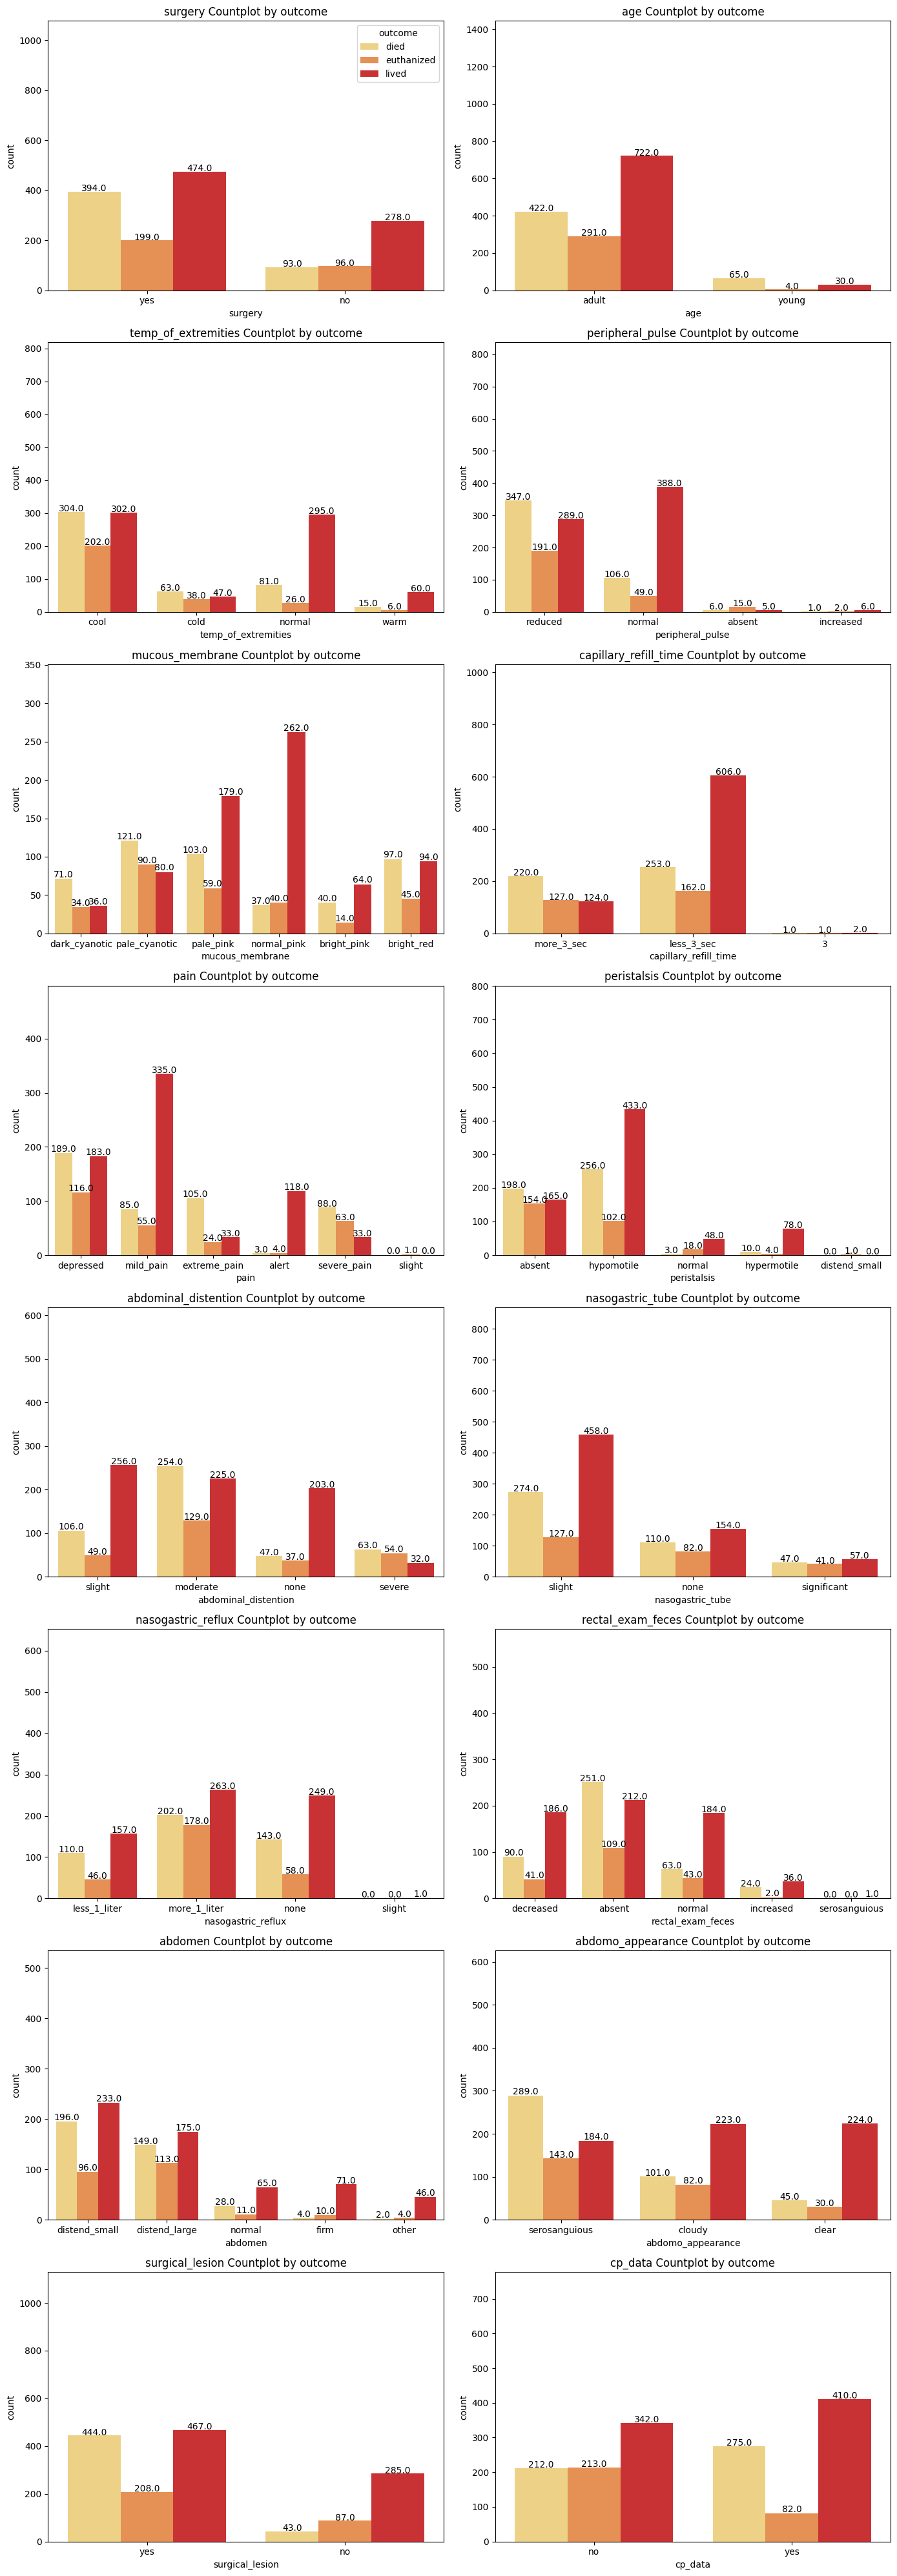

In [39]:
plt.figure(figsize=(14, len(categorical_feats)*2.5))

for idx, column in enumerate(categorical_feats):
    plt.subplot(len(categorical_feats)//2 + len(categorical_feats) % 2, 2, idx+1)
    ax = sns.countplot(x=column, data=train, hue='outcome', palette='YlOrRd')
    plt.title(f"{column} Countplot by outcome")
    plt.ylim(0, train[column].value_counts().max() + 10)

    for p in ax.patches:
        height = p.get_height()
        plt.text(p.get_x() + p.get_width()/2., height + 2, height, ha="center")

    # Remove duplicate legend
    if idx != 0:
        ax.get_legend().remove()

plt.tight_layout()
plt.show()

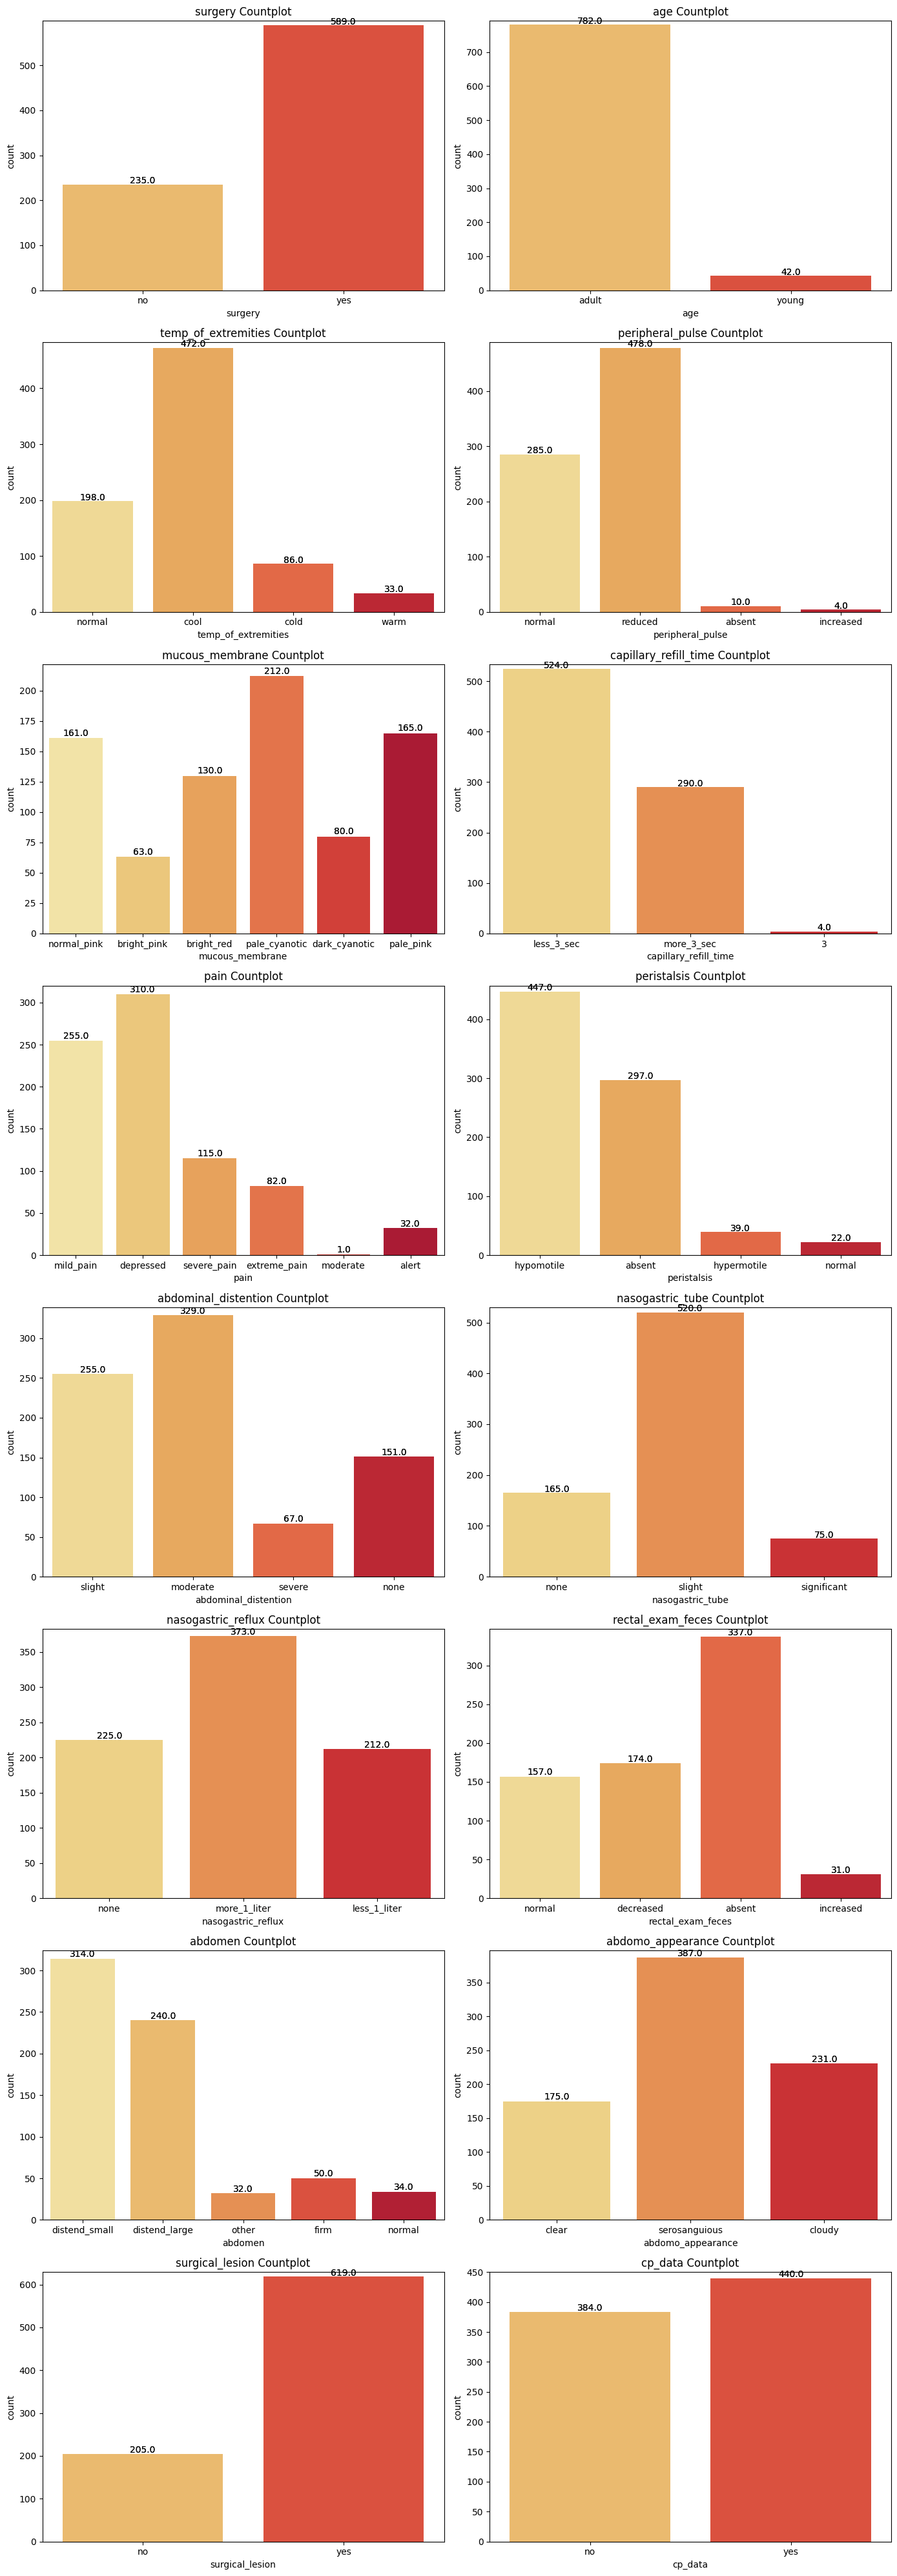

In [40]:
plt.figure(figsize=(14, len(categorical_feats)*2.5))

for idx, column in enumerate(categorical_feats):
    plt.subplot(len(categorical_feats)//2 + len(categorical_feats) % 2, 2, idx+1)
    sns.countplot(x=column, data=test, palette='YlOrRd')
    plt.title(f"{column} Countplot")

    plt.ylim(0, test[column].value_counts().max() + 10)

    # Add count labels above each rectangular bar
    for p in sns.countplot(x=column, data=test, palette='YlOrRd').patches:
        height = p.get_height()
        plt.text(p.get_x() + p.get_width()/2., height + 2, height, ha="center")

plt.tight_layout()
plt.show()

****there are some inconsistencies in the train data and test  , for example in pain there is slight  which doesnt exist in test data ( there is moderate instead )
rectal exam feces , there is serosanguious ( only 1 case ) which doesn't exist in test data ****

In [41]:
total["rectal_exam_feces"] = np.where(total["rectal_exam_feces"].isin(["serosanguious"]), total["rectal_exam_feces"].mode()[0], 
                                              total["rectal_exam_feces"])
total["pain"] = np.where(total["pain"].isin(["slight"]), "mild_pain", total["pain"])
total["peristalsis"] = np.where(total["peristalsis"].isin(["distend_small"]), total["peristalsis"].mode()[0], 
                                              total["peristalsis"])

total["nasogastric_reflux"] = np.where(total["nasogastric_reflux"].isin(["slight"]), 
                                               total["nasogastric_reflux"].mode()[0],
                                               total["nasogastric_reflux"])

total['capillary_refill_time'].replace({'3': 'more_3_sec'}, inplace=True)

In [42]:
total['frequency'] = total['hospital_number'].map(total['hospital_number'].value_counts())

****as the original data states , hospital number is merely an indicator for how many times did a horse visit the hosipital ( it still doesn't make sense to me because after analysing the data  , alot of  hospital numbers has many cases marked dead , how can a horse die more than one time ? ) ****

In [43]:
total.drop('hospital_number' , axis =1 , inplace = True )

In [44]:
total['frequency']

0       20
1       16
2        2
3        3
4        9
        ..
2353    83
2354     9
2355     5
2356    35
2357    19
Name: frequency, Length: 2358, dtype: int64

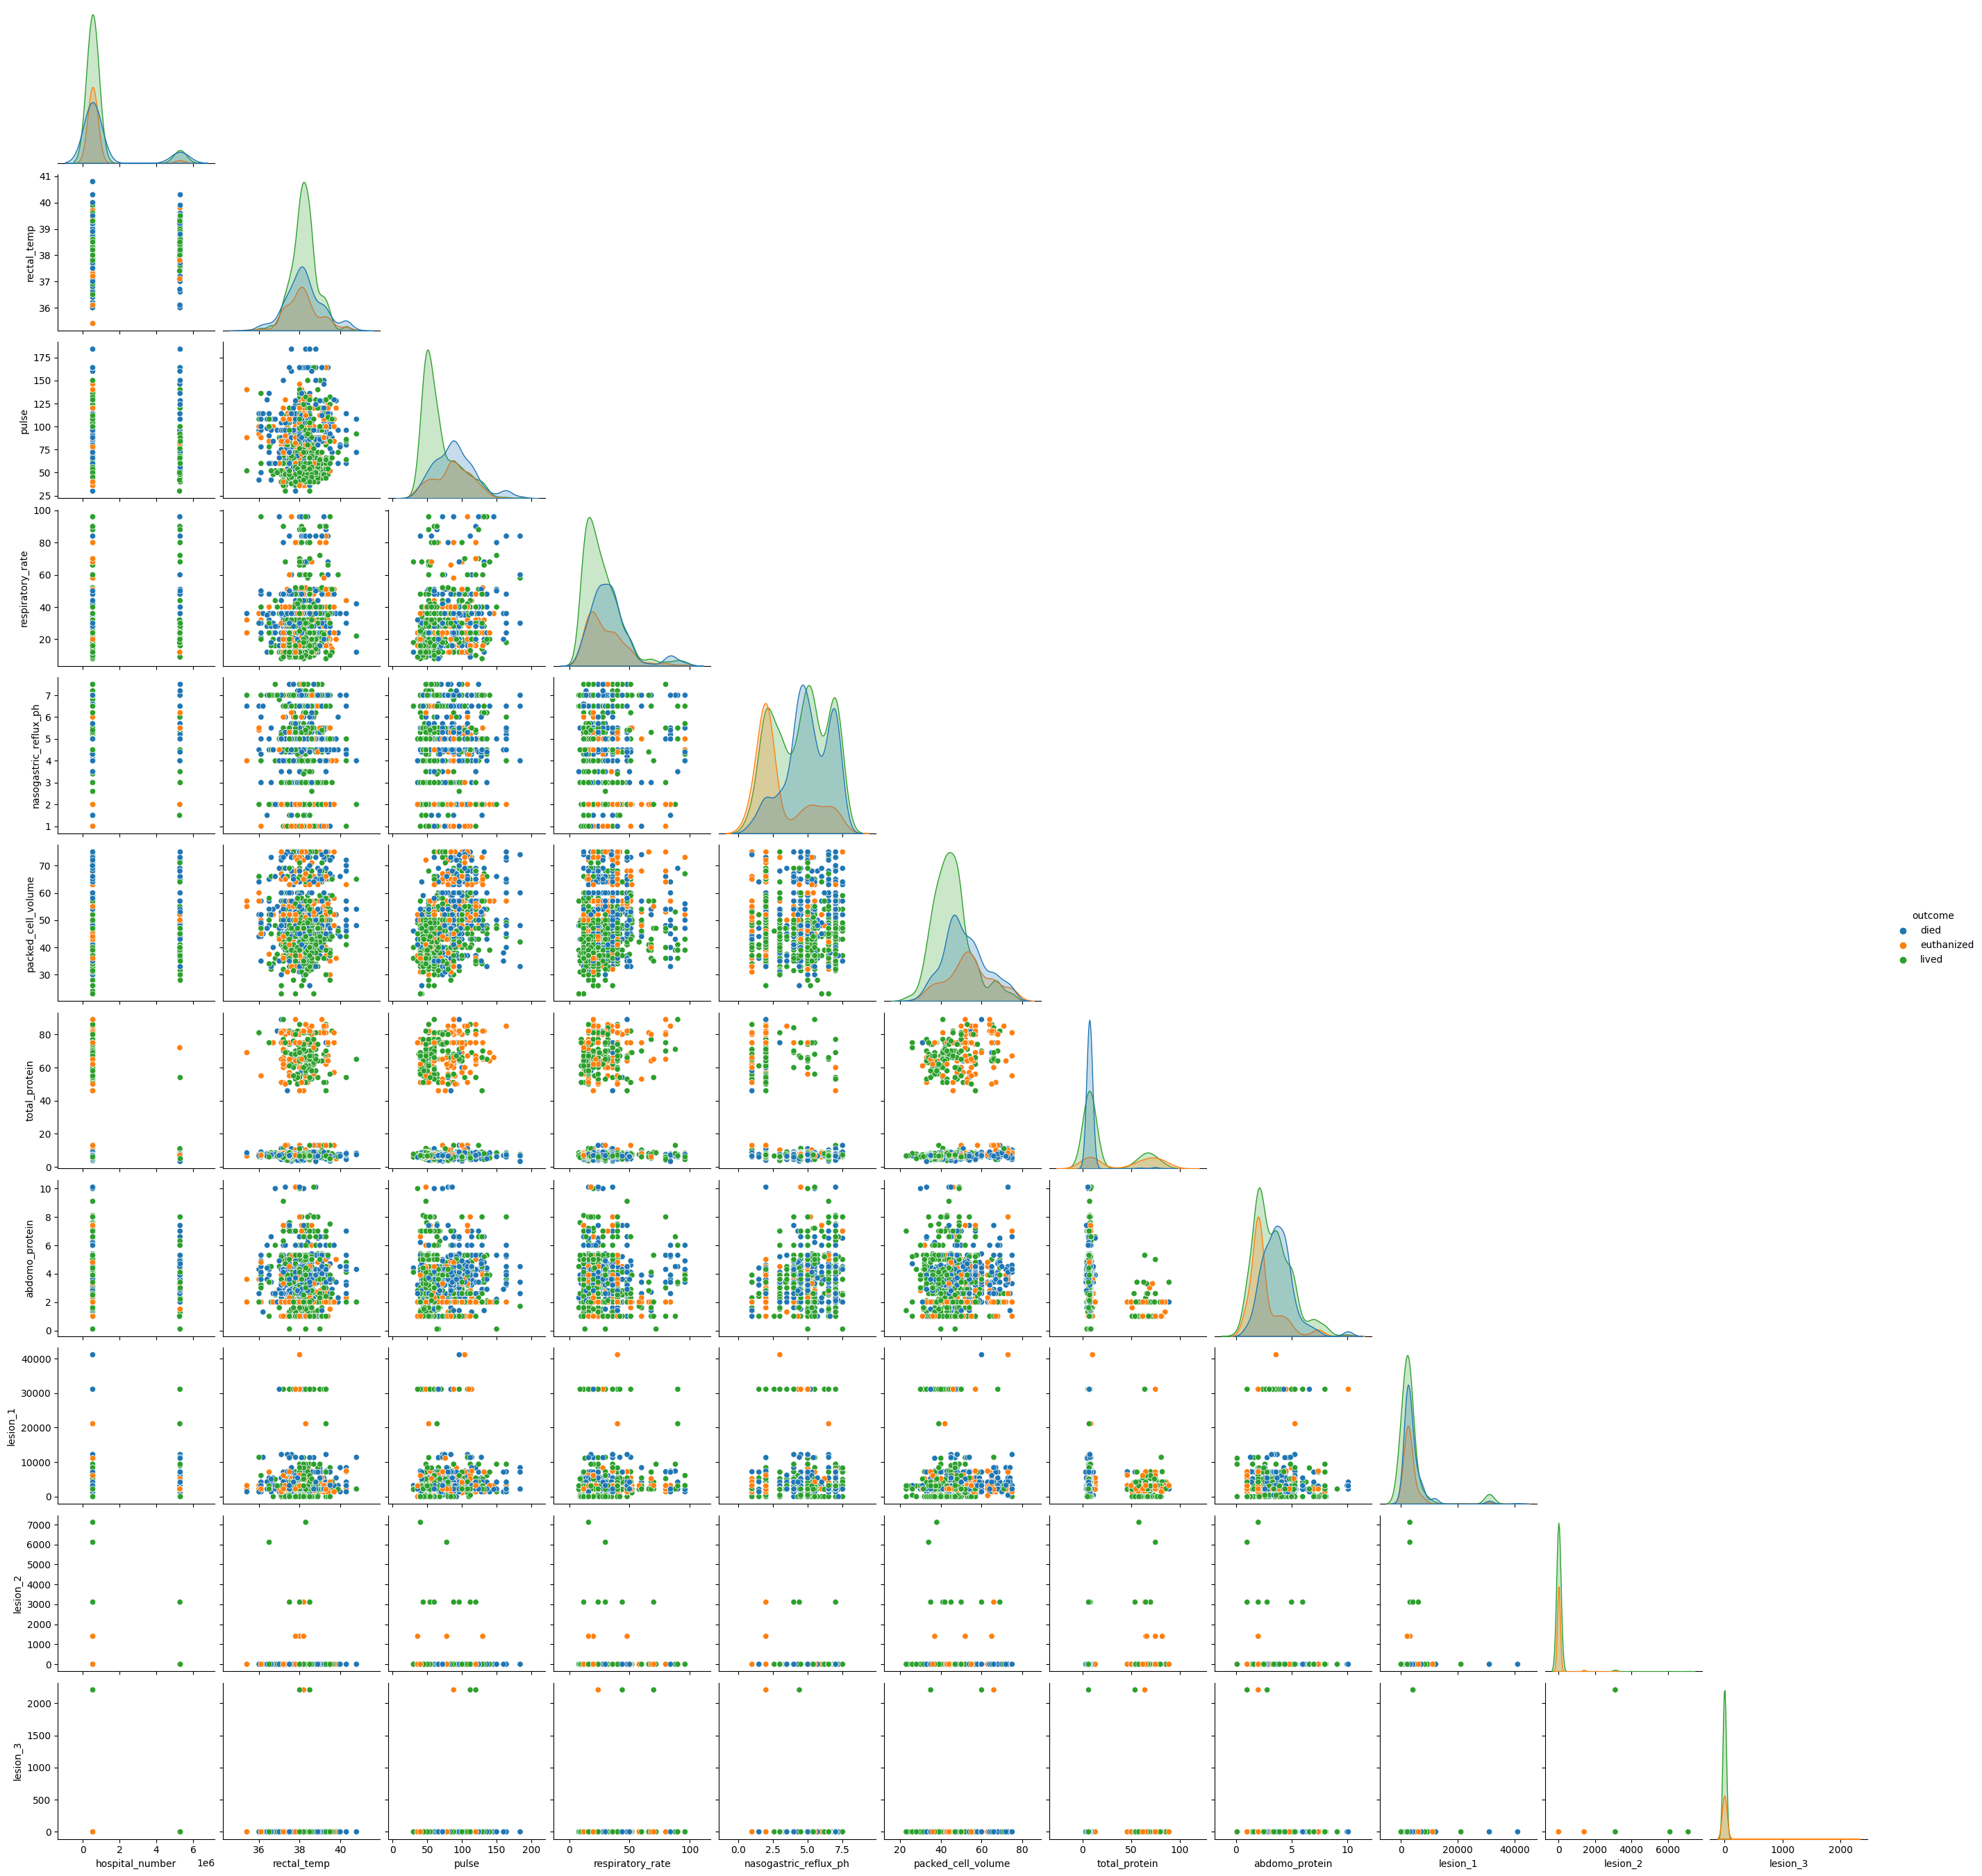

In [45]:
sns.pairplot(data=train[numerical_features+[target]], hue=target , corner=True)

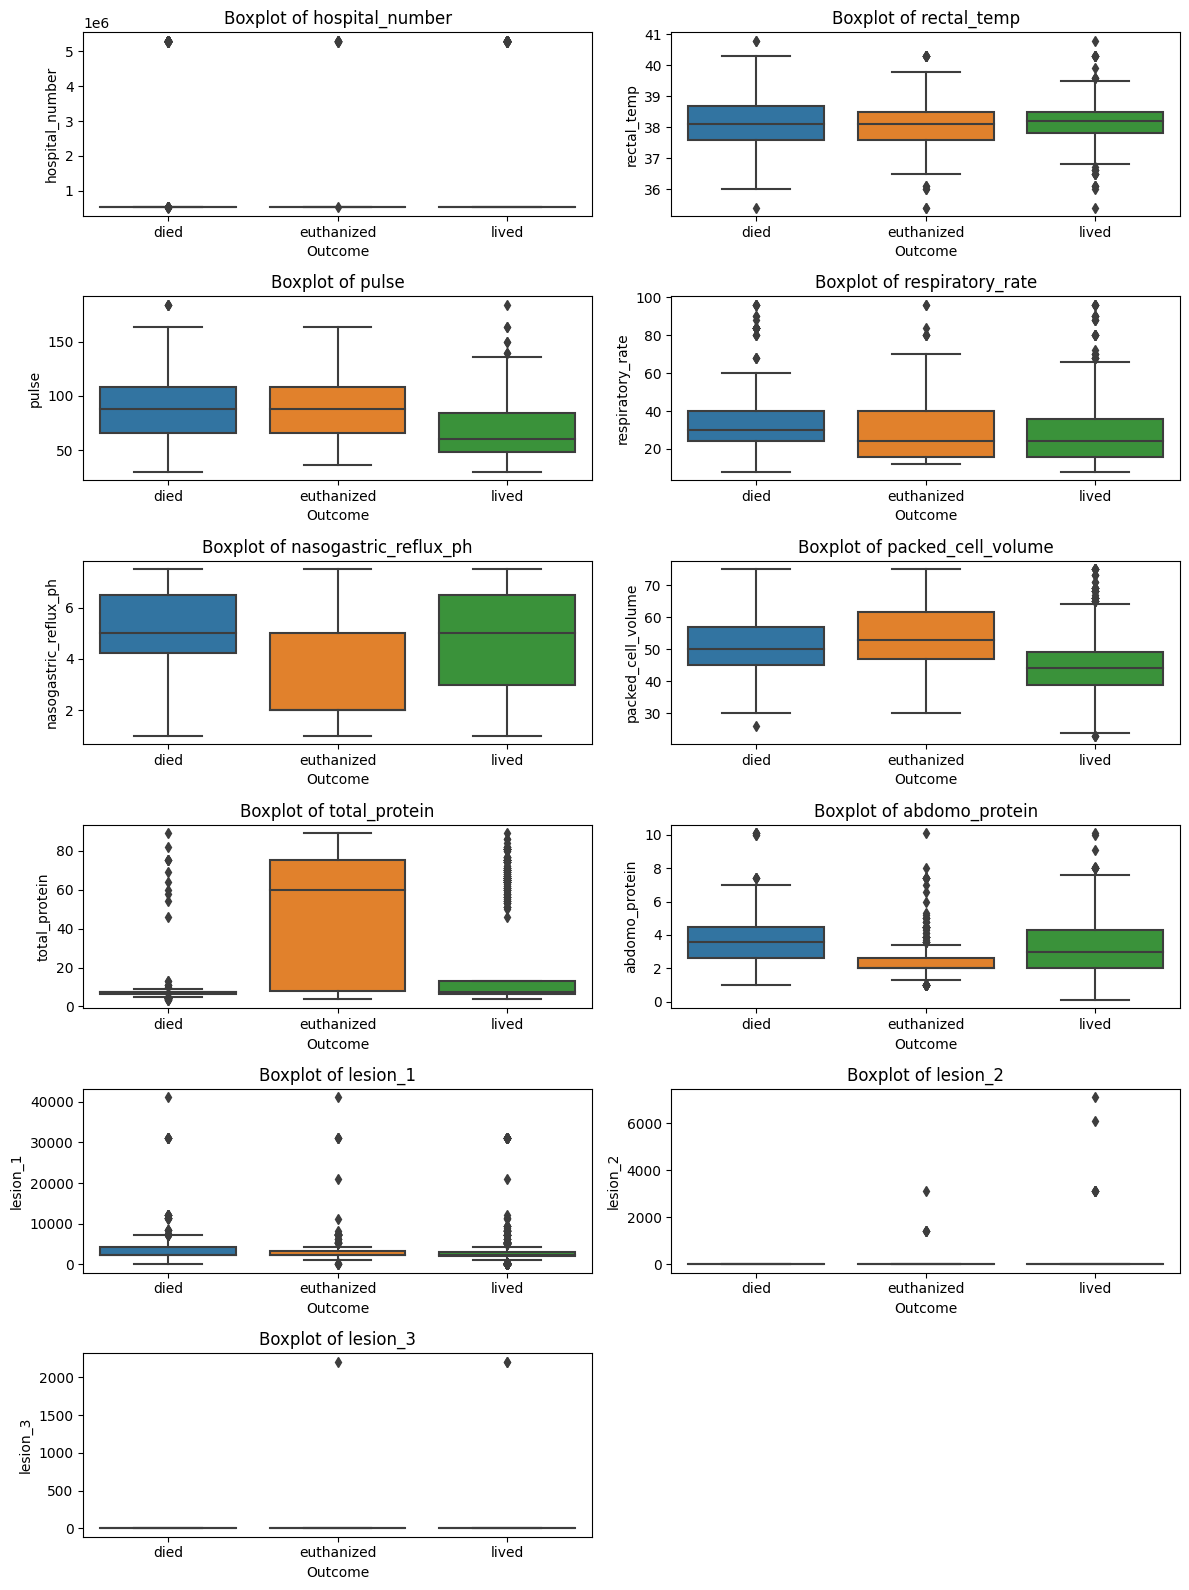

In [46]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 16))

for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    sns.boxplot(ax=axes[row, col], data=train, x='outcome', y=feature)
    axes[row, col].set_title(f'Boxplot of {feature}')
    axes[row, col].set_xlabel('Outcome')
    axes[row, col].set_ylabel(feature)

# Remove empty subplots if the number of features is not divisible by 2
if len(numerical_features) % 2 != 0:
    axes[-1, -1].remove()

plt.tight_layout()
plt.show()

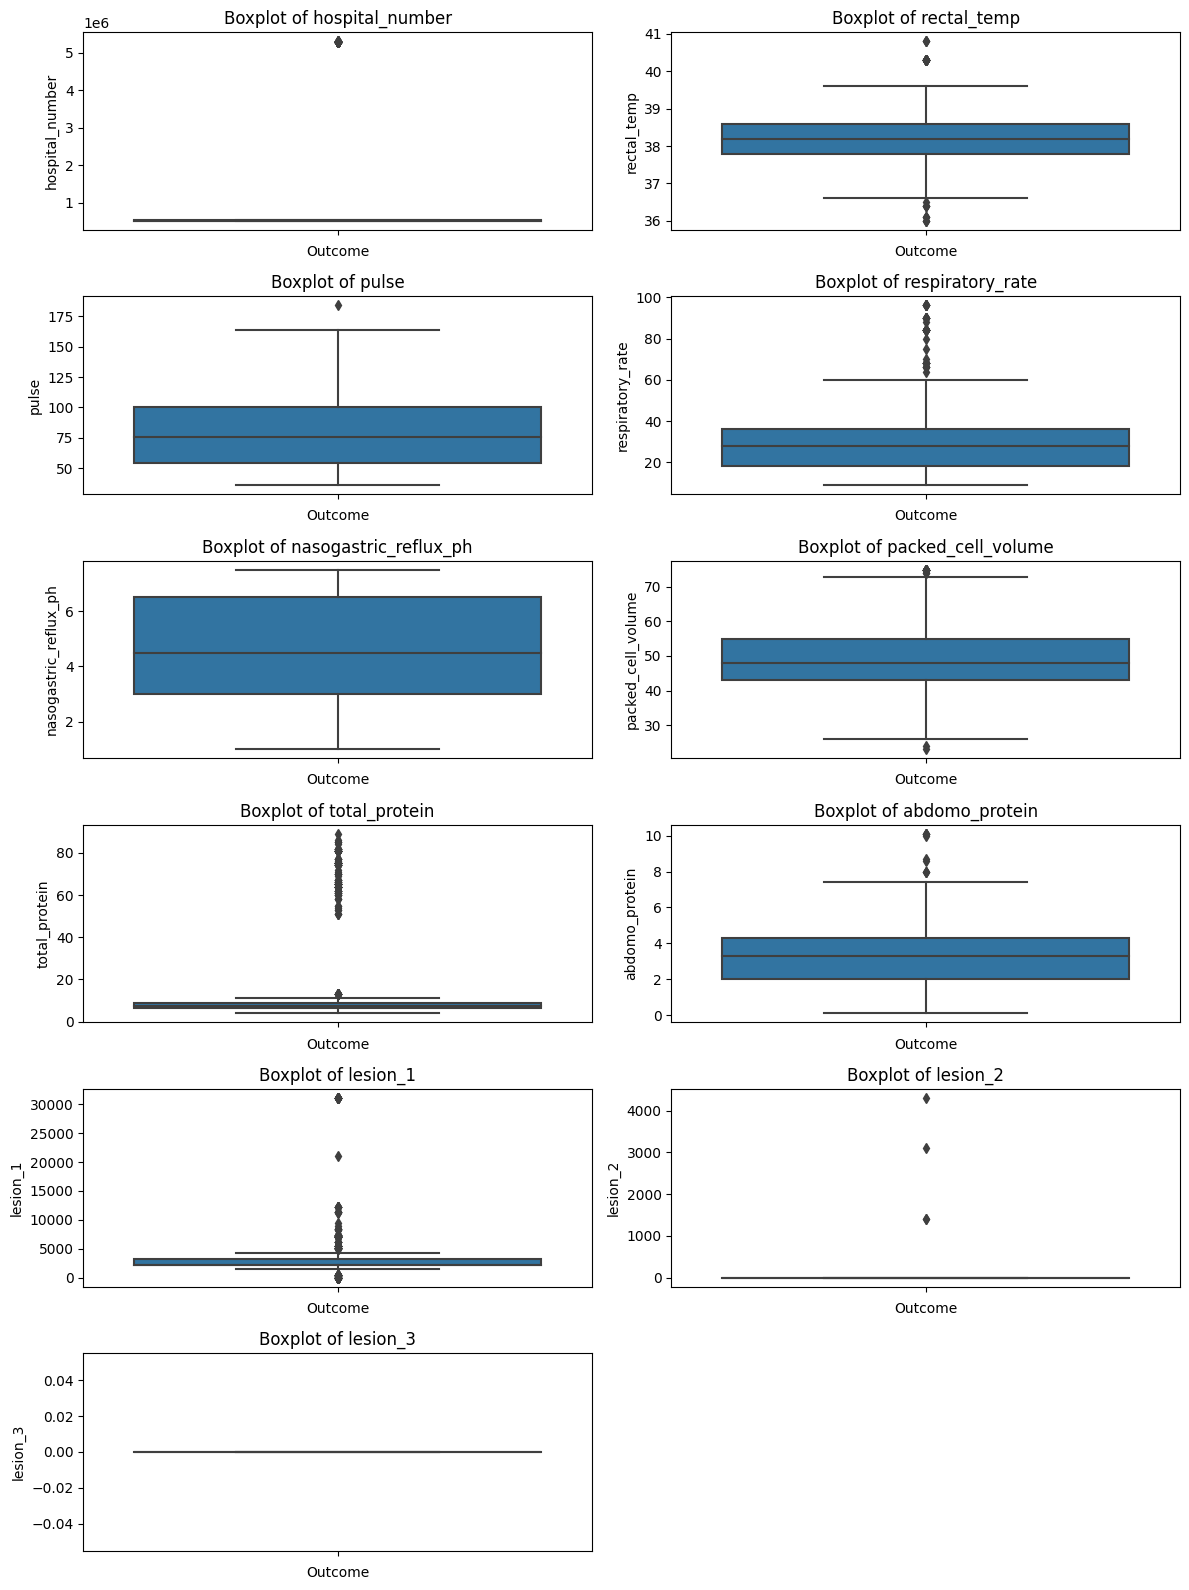

In [47]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(12, 16))

for i, feature in enumerate(numerical_features):
    row = i // 2
    col = i % 2
    sns.boxplot(ax=axes[row, col], data=test,  y=feature)
    axes[row, col].set_title(f'Boxplot of {feature}')
    axes[row, col].set_xlabel('Outcome')
    axes[row, col].set_ylabel(feature)

# Remove empty subplots if the number of features is not divisible by 2
if len(numerical_features) % 2 != 0:
    axes[-1, -1].remove()

plt.tight_layout()
plt.show()

****respiratory rate doesn't seem very good in influencing the outcome state for horses  
lesion 2 , lesion 3 are probably going to just add noise 
can work in total protein and packed cell volume to construct a feature which would be usefull , they seem some what well distributed ( if i have time i will work on this , if not i will just add my research  findings at the top i hope you find it useful :) )  
pulse is very solid as it seems , will probably be very effective indicator ****

****outliers on the other hand i can't seem to find a good solution for it (yet ) becuase for most features , there are too many of them everywhere in every category  to be considered "outliers" , tell me what you think **** 

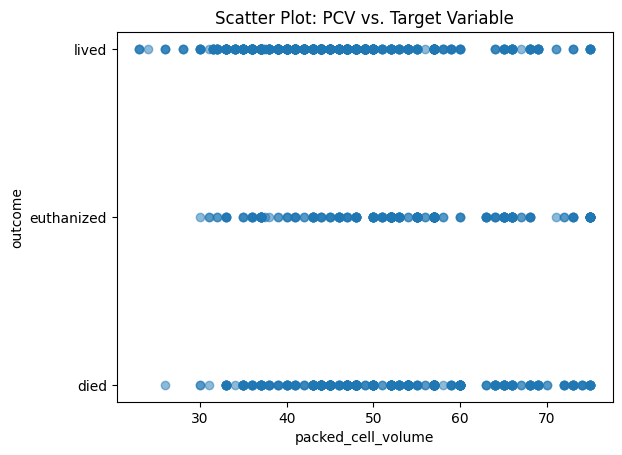

In [48]:

# Scatter plot for PCV vs. Target Variable
plt.scatter(train['packed_cell_volume'], train['outcome'], alpha=0.5)
plt.xlabel('packed_cell_volume')
plt.ylabel('outcome')
plt.title('Scatter Plot: PCV vs. Target Variable')
plt.show()

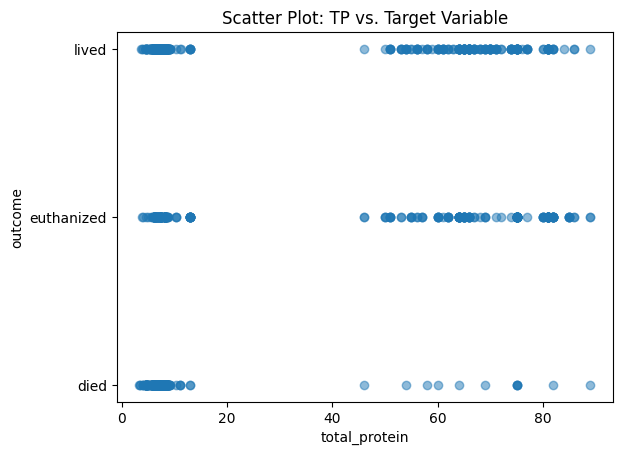

In [49]:
plt.scatter(train['total_protein'], train['outcome'], alpha=0.5)
plt.xlabel('total_protein')
plt.ylabel('outcome')
plt.title('Scatter Plot: TP vs. Target Variable')
plt.show()


In [50]:
correlation_matrix = total[['packed_cell_volume', 'total_protein', 'outcome']].corr()

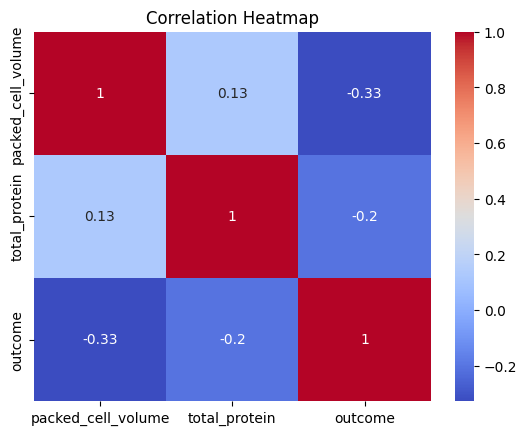

In [51]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [52]:
# trainpl['Combined_Feature'] = trainpl['packed_cell_volume'] + trainpl['total_protein']

In [53]:
# plt.scatter(total['Combined_Feature'], total['outcome'], alpha=0.5)
# plt.xlabel('Combined Feature')
# plt.ylabel('Target_Variable')
# plt.title('Scatter Plot: Combined Feature vs. Target Variable')
# plt.show()

In [54]:
# correlation_matrix2 = trainpl[['Combined_Feature', 'outcome']].corr()

In [55]:
# sns.heatmap(correlation_matrix2, annot=True, cmap='coolwarm')
# plt.title('Correlation Heatmap')
# plt.show()


In [56]:
def IQR(col):
    q1 = np.percentile(col, 25)
    q3 = np.percentile(col, 75)
    iqr = q3 - q1
    upper_bound = q3 + (1.5 * iqr)
    upper_outliers = col > upper_bound

    # Replace outliers with upper bound values
    col = np.where(upper_outliers, round(upper_bound, 2), col)  
    return col


total["total_protein"] = IQR(total["total_protein"])



In [57]:
# total['pcv_tp_ratio']=total['packed_cell_volume']/total['total_protein']

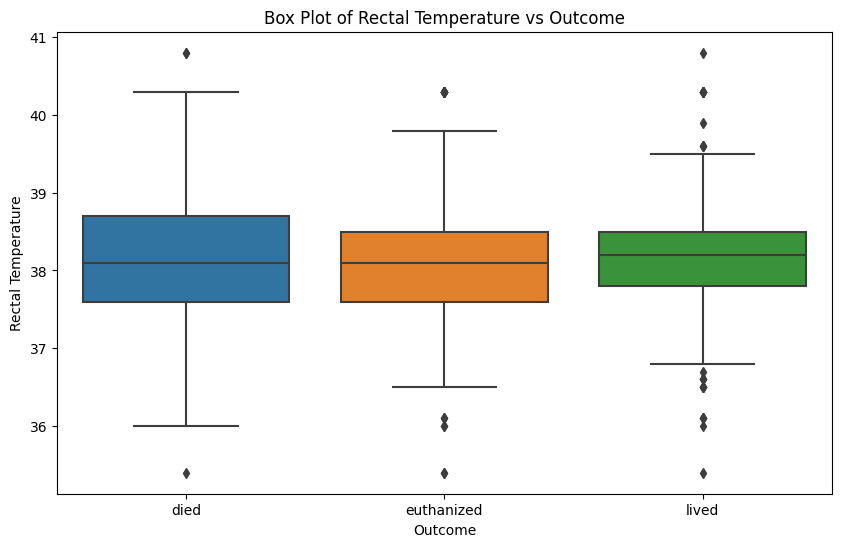

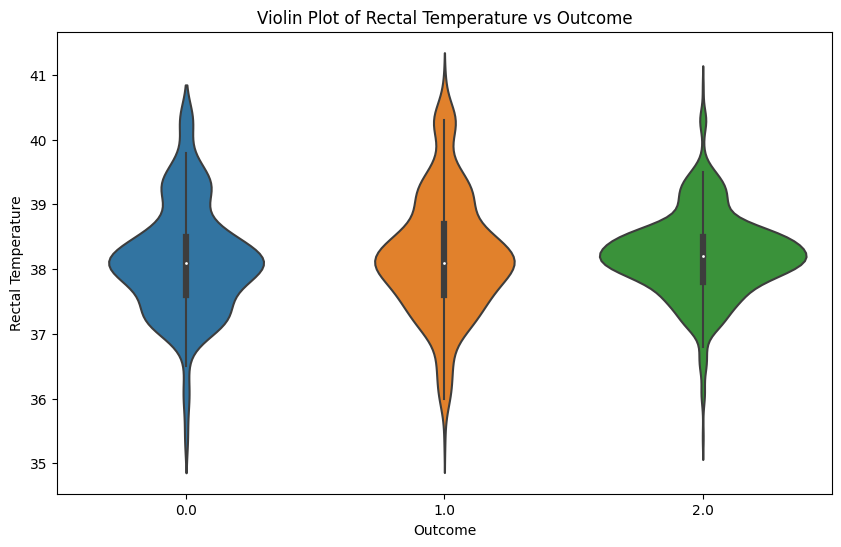

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='outcome', y='rectal_temp', data=train)
plt.title('Box Plot of Rectal Temperature vs Outcome')
plt.xlabel('Outcome')
plt.ylabel('Rectal Temperature')
plt.show()

# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='outcome', y='rectal_temp', data=total)
plt.title('Violin Plot of Rectal Temperature vs Outcome')
plt.xlabel('Outcome')
plt.ylabel('Rectal Temperature')
plt.show()

In [59]:
# print(train[train['lesion_1'] ==11300 ]['outcome'].value_counts())

In [60]:
# train[train['lesion_1'] > 9999]['lesion_1'].value_counts()

In [61]:

total['lesion_1'] = total['lesion_1'].astype(str)
site_of_lesion_mapping = {
    '1': 'gastric',
    '2': 'small intestine',
    '3': 'large colon',
    '4': 'large colon and cecum',
    '5': 'cecum',
    '6': 'transverse colon',
    '7': 'rectum/descending colon',
    '8': 'uterus',
    '9': 'bladder',
    '11': 'all intestinal sites',
    '0': 'none',
}

type_mapping = {
    '1': 'simple',
    '2': 'strangulation',
    '3': 'inflammation',
    '4': 'other',
}

subtype_mapping = {
    '1': 'mechanical',
    '2': 'paralytic',
    '0': 'n/a',
}

specific_code_mapping = {
    '1': 'obturation',
    '2': 'intrinsic',
    '3': 'extrinsic',
    '4': 'adynamic',
    '5': 'volvulus/torsion',
    '6': 'intussusception',
    '7': 'thromboembolic',
    '8': 'hernia',
    '9': 'lipoma/splenic incarceration',
    '10': 'displacement',
    '0': 'n/a',
}


total['site'] = total['lesion_1'].str[0].map(site_of_lesion_mapping)
total['type'] = total['lesion_1'].str[1].map(type_mapping)
total['subtype'] = total['lesion_1'].str[2].map(subtype_mapping)
total['specific_code'] = total['lesion_1'].str[3].map(specific_code_mapping)
special_cases = {
    '31110': ('large colon', 'simple', 'mechanical', 'displacement'),
    '12208': ('small intestine', 'strangulation', 'n/a', 'hernia'),
    '11300': ('gastric', 'simple', 'n/a', 'n/a'),
    '11400': ('all intestinal sites', 'other', 'n/a', 'n/a'),
    '11124': ('all intestinal sites', 'simple', 'paralytic', 'adynamic'),
    '21110': ('small intestine', 'simple', 'mechanical', 'displacement'),
    '41110': ('large colon and cecum', 'simple', 'mechanical', 'displacement'),
}


for case, (site, type, subtype, specific_code) in special_cases.items():
    total.loc[total['lesion_1'] == case, 'site'] = site
    total.loc[total['lesion_1'] == case, 'type'] = type
    total.loc[total['lesion_1'] == case, 'subtype'] = subtype
    total.loc[total['lesion_1'] == case, 'specific_code'] = specific_code

total.drop(['lesion_1', 'lesion_2', 'lesion_3'], axis=1, inplace=True)


****decoding lesion as the original dataset  clarified  ( update : subtype doesn't seem to be relevant to the outcome , dropping it proved to be worth , as for lesion 2 and 3  they have very little cases ) ****

In [62]:
total['site'].value_counts()

site
small intestine            1016
large colon                 577
none                        209
large colon and cecum       165
gastric                     113
cecum                       112
rectum/descending colon     101
uterus                       22
transverse colon             21
all intestinal sites         12
bladder                      10
Name: count, dtype: int64

In [63]:
categorical_feats = []
for column in total.columns:
   
    if total[column].dtype == 'object':
    
        categorical_feats.append(column)


print(categorical_feats)

['surgery', 'age', 'temp_of_extremities', 'peripheral_pulse', 'mucous_membrane', 'capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'surgical_lesion', 'cp_data', 'site', 'type', 'subtype', 'specific_code']


In [64]:
numerical_features = []


for column in total.columns:
    
    if pd.api.types.is_numeric_dtype(total[column]):
     
        numerical_features.append(column)


print(numerical_features)

['rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'outcome', 'frequency']


In [65]:
def plot_correlation_matrix(data, numerical_features):
    # Select the numerical features
    numerical_data = data[numerical_features]

    # Compute the correlation matrix
    correlation_matrix = numerical_data.corr()

    # Generate a mask for the upper triangle to hide redundant values
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create a custom colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Plot the correlation matrix
    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, center=0, annot=True,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

    # Customize the plot
    plt.title("Correlation Matrix of Numerical Features")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Show the plot
    plt.show()

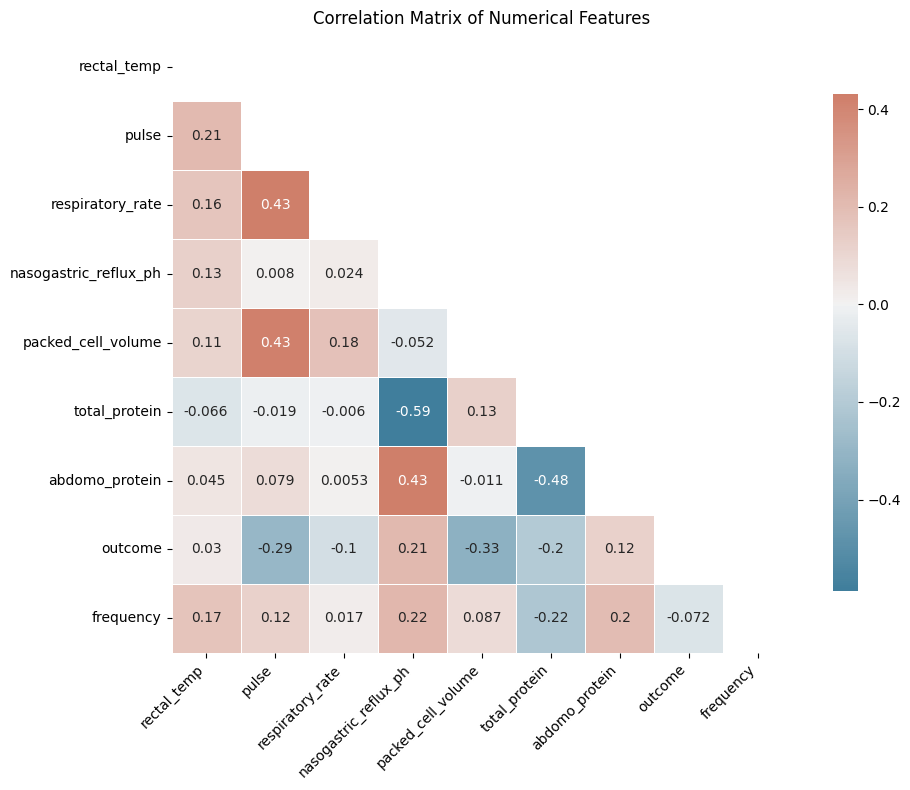

In [66]:
plot_correlation_matrix(total, numerical_features)

In [67]:
numerical_features.remove('outcome')

In [68]:
for col in categorical_feats:
    total[col] = total[col].fillna(total[col].mode()[0])

imputer = KNNImputer(n_neighbors=8)  
total[numerical_features] = imputer.fit_transform(total[numerical_features])

****would be better to use KNN imputer  ( will try in later vesrion ) ****

In [69]:
# def chi_squared_test(df, input_var, target_var, significance_level=0.05):
#     contingency_table = pd.crosstab(df[input_var], df[target_var])
    
    
#     chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
#     if p < significance_level:
#         print(f'\033[32m{input_var} has a significant relationship with the target variable.\033[0m') 
#     else:
#         print(f'\033[31m{input_var} does not have a significant relationship with the target variable.\033[0m')  
    
# for i in categorical_feats:
#     chi_squared_test(total, i, target)

In [70]:
total['mucous_membrane'].unique()

array(['dark_cyanotic', 'pale_cyanotic', 'pale_pink', 'normal_pink',
       'bright_pink', 'bright_red'], dtype=object)

In [71]:

pulse_threshold = 80  
mucous_membrane_colors = ['pale_cyanotic', 'dark_cyanotic']
capillary_refill_criteria = 'more_3_sec'
pain_levels = ['severe_pain']
respiratory_rate_threshold = 25  
temperature_of_extremities_criteria = ['cold']  
perpulse = ['absent']
abdominal_distention = ['severe']
rectal = 36


pulse_weight = 0.3
mucous_membrane_weight = 0.25
capillary_refill_weight = 0.15
pain_weight = 0.2
respiratory_rate_weight = 0.15  
temperature_of_extremities_weight = 0.15 
peripheral_pulse_weight = 0.15
abdominal_distention_weight = 0.15
rectal_weight = 0.05



def calculate_shock_probability(row):
    
    probability = 0  

   
    if row['pulse'] > pulse_threshold:
        probability += pulse_weight
    if row['mucous_membrane'] in mucous_membrane_colors:
        probability += mucous_membrane_weight
    if row['capillary_refill_time'] == capillary_refill_criteria:
        probability += capillary_refill_weight
    if row['pain'] in pain_levels:
        probability += pain_weight
    if row['respiratory_rate'] > respiratory_rate_threshold:
        probability += respiratory_rate_weight
    if row['temp_of_extremities'] == temperature_of_extremities_criteria:
        probability += temperature_of_extremities_weight
        
    if row['peripheral_pulse'] == perpulse:
        probability += peripheral_pulse_weight   
    if row['abdominal_distention'] == abdominal_distention:
        probability += abdominal_distention_weight      

    if row['rectal_temp'] < rectal:
        probability += rectal_weight   
       
  
    probability = min(max(probability, 0), 1)

    return probability


total['shock_probability'] = total.apply(calculate_shock_probability, axis=1)


print(total['shock_probability'].describe())

count   2,358.00
mean        0.36
std         0.30
min         0.00
25%         0.00
50%         0.30
75%         0.60
max         1.00
Name: shock_probability, dtype: float64


In [72]:
total["rectal_temp"] = (total["rectal_temp"] - 37.8).abs()

****its better to calculate the deviation rather than the values itselt ****

In [73]:
encodings = {
    ('none', 'clear'): 11,
    ('slight', 'clear'): 10,
    ('none', 'cloudy'): 9,
    ('slight', 'cloudy'): 8,
    ('moderate', 'clear'): 7,
    ('moderate', 'cloudy'): 6,
    ('severe', 'clear'): 5,
    ('severe', 'cloudy'): 4,
    ('none', 'serosanguious'): 3,
    ('slight', 'serosanguious'): 2,
    ('moderate', 'serosanguious'): 1,
    ('severe', 'serosanguious'): 0
}

# Create the new encoded feature using the combinations
total['encoded_combination'] = total.apply(lambda row: encodings[(row['abdominal_distention'], row['abdomo_appearance'])], axis=1)

# Print the updated DataFrame to see the new feature
print(total['encoded_combination'].value_counts())

encoded_combination
1     665
2     298
6     247
8     184
10    184
9     159
3     144
0     140
11    135
7     126
4      47
5      29
Name: count, dtype: int64


****after trying various plots , these are my findings about possible abdominal_distention and  abdomo_appearance  ( arranged them from worst to best where 0 is the worst ****

In [74]:
total.drop(['abdominal_distention', 'abdomo_appearance'], axis=1, inplace=True)

In [75]:
total["temp_of_extremities"] = total["temp_of_extremities"].map({'cool':0,'cold':1,'warm':2,'normal':3 })
total["peripheral_pulse"] = total["peripheral_pulse"].map({'absent':0,'reduced':1,'increased':2,'normal':3})
total["capillary_refill_time"] = total["capillary_refill_time"].map({'more_3_sec':0,'less_3_sec':1})
total["pain"] = total["pain"].map({'severe_pain':0.0,'extreme_pain':1.0,'depressed':2.0,'moderate':3.0,'mild_pain':4.0,'alert':5.0})
total["peristalsis"] = total["peristalsis"].map({'absent':0,'hypermotile':1,'hypomotile':2,'normal':3})

total["nasogastric_reflux"] = total["nasogastric_reflux"].map({'more_1_liter':0,'less_1_liter':1,'none':2})
total["rectal_exam_feces"] = total["rectal_exam_feces"].map({"absent":0,'decreased':1,'increased':2,'normal':3})
total["nasogastric_tube"] = total["nasogastric_tube"].map({'significant':0,'slight':1,'none':2})
# total["abdominal_distention"] = total["abdominal_distention"].map({'none':0,'slight':1,'moderate':2,'severe':3})
# total["abdomo_appearance"] = total["abdomo_appearance"].map({'serosanguious':0,'cloudy':1,'clear':2})
total["abdomen"] = total["abdomen"].map({'distend_large':0,'distend_small':1,'firm':2,'other':3,'normal':4})
total["site"] = total["site"].map({'gastric':0,'small intestine':1,'large colon':2,'large colon and cecum':4,'cecum':3 , 'transverse colon':5,'rectum/descending colon':6,'uterus':7, 'bladder':8 ,'all intestinal sites':10 ,'none':9 })
total["type"] = total["type"].map({'simple':3,'inflammation':2,'strangulation':1,'other':0})
# total["subtype"] = total["subtype"].map({'paralytic':0,'mechanical':1,'n/a':2})
total["specific_code"] = total["specific_code"].map({'lipoma/splenic incarceration':0,'hernia':1,'adynamic':2,'volvulus/torsion':4,'obturation':3 , 'thromboembolic':5,'intussusception':6,'extrinsic':7, 'intrinsic':8 ,'n/a':9 ,'displacement':10 })
# total["mucous_membrane"] = total["mucous_membrane"].map({'dark_cyanotic' : 0 , 'pale_cyanotic' : 1 , 'bright_red':2 , 'pale_pink' : 4 , 'bright_pink': 3 , 'normal_pink' : 5})
total["surgery"] = total["surgery"].map({'yes':0,'no':1})
total["age"] = total["age"].map({'young':0,'adult':1})
total["surgical_lesion"] = total["surgical_lesion"].map({'yes':0,'no':1})
total["cp_data"] = total["cp_data"].map({'no':0,'yes':1})

In [76]:
categorical_feats = []
for column in total.columns:
   
    if total[column].dtype == 'object':
       
        categorical_feats.append(column)


print(categorical_feats)

['mucous_membrane', 'subtype']


In [77]:
numerical_features = []


for column in total.columns:
    
    if pd.api.types.is_numeric_dtype(total[column]):
     
        numerical_features.append(column)


print(numerical_features)

['surgery', 'age', 'rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse', 'capillary_refill_time', 'pain', 'peristalsis', 'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein', 'abdomo_protein', 'surgical_lesion', 'cp_data', 'outcome', 'frequency', 'site', 'type', 'specific_code', 'shock_probability', 'encoded_combination']


In [78]:
encfeats=['surgery','age','surgical_lesion','cp_data','mucous_membrane']

In [79]:
total_ohe = pd.get_dummies(total, columns=encfeats)


In [80]:
total_ohe.columns

Index(['rectal_temp', 'pulse', 'respiratory_rate', 'temp_of_extremities',
       'peripheral_pulse', 'capillary_refill_time', 'pain', 'peristalsis',
       'nasogastric_tube', 'nasogastric_reflux', 'nasogastric_reflux_ph',
       'rectal_exam_feces', 'abdomen', 'packed_cell_volume', 'total_protein',
       'abdomo_protein', 'outcome', 'frequency', 'site', 'type', 'subtype',
       'specific_code', 'shock_probability', 'encoded_combination',
       'surgery_0', 'surgery_1', 'age_0', 'age_1', 'surgical_lesion_0',
       'surgical_lesion_1', 'cp_data_0', 'cp_data_1',
       'mucous_membrane_bright_pink', 'mucous_membrane_bright_red',
       'mucous_membrane_dark_cyanotic', 'mucous_membrane_normal_pink',
       'mucous_membrane_pale_cyanotic', 'mucous_membrane_pale_pink'],
      dtype='object')

In [81]:
total_ohe.drop(['cp_data_0', 'age_0', 'surgical_lesion_0','surgery_0', 'subtype','mucous_membrane_bright_pink'], axis=1, inplace=True)

In [82]:
total_ohe.drop(['respiratory_rate' , 'abdomo_protein'], axis=1, inplace=True)

In [83]:
total.isna().sum()

surgery                    0
age                        0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities        0
peripheral_pulse           0
mucous_membrane            0
capillary_refill_time      0
pain                       0
peristalsis                0
nasogastric_tube           0
nasogastric_reflux         0
nasogastric_reflux_ph      0
rectal_exam_feces          0
abdomen                    0
packed_cell_volume         0
total_protein              0
abdomo_protein             0
surgical_lesion            0
cp_data                    0
outcome                  824
frequency                  0
site                       0
type                       0
subtype                    0
specific_code              0
shock_probability          0
encoded_combination        0
dtype: int64

In [84]:
train_l = total_ohe[total_ohe[target].notnull()]
test_l = total_ohe[total_ohe[target].isnull()].drop(columns=[target])

In [85]:

X_train = train_l.drop(columns=['outcome'])
y_train = train_l['outcome']  

In [86]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(test_l)

In [87]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=test_l.columns)

In [88]:
# # Fit PCA to your data
# pca = PCA()
# pca.fit(X_train_scaled)

# # Plot explained variance
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_explained_variance = np.cumsum(explained_variance_ratio)
# target_variance = 0.99999999999999

# # Find the number of components to retain
# num_components = np.argmax(cumulative_explained_variance >= target_variance) + 1  # Adding 1 to convert to number of components

# print("Number of components to retain:", num_components)
# # Get the indices of the components sorted by their explained variance
# component_indices = np.argsort(pca.explained_variance_ratio_)[::-1]

# # Get the component names for the selected components in the correct order
# selected_component_names = [X_train.columns[i] for i in component_indices[:num_components]]


# # Print the component names
# print("Selected Component Names:")
# for component_name in selected_component_names:
#     print(component_name)

# # Plot explained variance
# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Explained Variance vs. Number of Components')
# plt.grid(True)
# plt.show()

****i left the code for PCA and Random Forest Classifier for feature selection ( use it if you see fit it fits your preprocessing needs ) ****

In [89]:
# X_train_pca_selected = X_train_scaled[selected_component_names]

In [90]:

# X_test_pca_selected = X_test_scaled[selected_component_names]

In [91]:

# rf_classifier = RandomForestClassifier(random_state=42)


# rf_classifier.fit(X_train_scaled, y_train)

In [92]:

# feature_importances = rf_classifier.feature_importances_




# sorted_indices = (-feature_importances).argsort()


# top_n = 62  # Adjust as needed
# top_feature_names = [selected_component_names[i] for i in sorted_indices[:top_n]]
# top_feature_importances = feature_importances[sorted_indices[:top_n]]


# plt.figure(figsize=(10, 6))
# plt.barh(range(top_n), top_feature_importances, align='center')
# plt.yticks(range(top_n), top_feature_names)
# plt.xlabel('Feature Importance')
# plt.title('Top {} Feature Importances'.format(top_n))
# plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top
# plt.show()

In [93]:
# X_train_lst = X_train_pca_selected.iloc[: , sorted_indices[:top_n]]

In [94]:
# X_test_lst = X_test_pca_selected.iloc[: , sorted_indices[:top_n]]

In [95]:
# X_test_last = X_test_pca_selected.iloc[: , sorted_indices[:top_n]]

In [96]:
X = X_train_scaled
y = y_train.astype(int)

In [97]:
X.shape

(1534, 29)

In [98]:
y.shape

(1534,)

In [99]:
y.value_counts()

outcome
2    752
1    487
0    295
Name: count, dtype: int64

# model creation

# decision tree

In [100]:

# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.model_selection import GridSearchCV



# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Create a decision tree classifier
# clf = DecisionTreeClassifier()

# # Define a grid of hyperparameters to search over
# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [None, 10, 20, 30],  # You can adjust the depth values
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],  # You can adjust this based on the number of features
#     'random_state': [42]
# }

# # Perform grid search with cross-validation to find the best hyperparameters
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters from the grid search
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Create a decision tree classifier with the best hyperparameters
# best_clf = DecisionTreeClassifier(**best_params)

# # Fit the classifier to the training data
# best_clf.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = best_clf.predict(X_test)

# # Calculate the accuracy of the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# light GBM with grid search

In [101]:


# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Create a LightGBM dataset
# train_data = lgb.Dataset(X_train, label=y_train)

# # Define hyperparameters for tuning
# param_grid = {
#     'objective': ['multiclass'],
#     'num_class': [3],
#     'boosting_type': ['gbdt'],
#     'metric': ['multi_logloss'],
#     'num_leaves': [31, 50, 100],   
#     'max_depth': [-1],             
#     'learning_rate': [0.05, 0.1],  
#     'feature_fraction': [1.0],     
#     'bagging_fraction': [0.8],    
#     'bagging_freq': [5],
#     'verbose': [-1],
#     'seed': [42],
# }


# clf = lgb.LGBMClassifier()

# # Perform grid search with cross-validation to find the best hyperparameters
# grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# # Get the best hyperparameters from the grid search
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

# # Create a LightGBM classifier with the best hyperparameters
# best_clf = lgb.LGBMClassifier(**best_params)

# # Train the classifier on the training data
# best_clf.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = best_clf.predict(X_test)

# # Calculate accuracy and ROC AUC
# accuracy = accuracy_score(y_test, y_pred)
# y_prob = best_clf.predict_proba(X_test)
# roc_auc = roc_auc_score(y_test, y_prob, multi_class='ovr')

# print(f"Accuracy: {accuracy}")
# print(f"ROC AUC: {roc_auc}")

# # Plot the learning curve
# def plot_learning_curve(estimator, X, y):
#     train_sizes, train_scores, valid_scores = learning_curve(
#         estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy'
#     )

#     train_mean = np.mean(train_scores, axis=1)
#     train_std = np.std(train_scores, axis=1)
#     valid_mean = np.mean(valid_scores, axis=1)
#     valid_std = np.std(valid_scores, axis=1)

#     plt.figure(figsize=(10, 6))
#     plt.plot(train_sizes, train_mean, marker='o', label='Training Accuracy', color='b')
#     plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='b')
#     plt.plot(train_sizes, valid_mean, marker='o', label='Validation Accuracy', color='g')
#     plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.15, color='g')

#     plt.title('Learning Curve')
#     plt.xlabel('Training Examples')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='best')
#     plt.grid()
#     plt.show()

# # Plot the learning curve for the best LightGBM classifier
# plot_learning_curve(best_clf, X_train, y_train)

# light GBM with optuna

In [102]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, valid_scores = learning_curve(
        estimator, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, scoring='accuracy'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, marker='o', label='Training Accuracy', color='b')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='b')
    plt.plot(train_sizes, valid_mean, marker='o', label='Validation Accuracy', color='g')
    plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, alpha=0.15, color='g')

    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [103]:


    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    k_best = SelectKBest(score_func=f_classif, k='all')
    X_train_best = k_best.fit_transform(X_train, y_train)
    X_test_best = k_best.transform(X_test)
    tt = k_best.transform(X_test_scaled)
    

In [104]:
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 3,
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 31, 100),
        'max_depth': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1),
        'feature_fraction': 1.0,
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': 5,
        'verbose': -1,
        'seed': 42,
    }

    # Create a LightGBM classifier with the trial parameters
    clf = lgb.LGBMClassifier(**params)

    # Use 5-fold cross-validation to evaluate the model
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y, cv=cv, scoring='accuracy')

    # Calculate the mean accuracy from cross-validation
    accuracy = np.mean(scores)

    return accuracy


In [105]:
# Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # You can adjust the number of trials

#the best hyperparameters
best_params = study.best_params
best_accuracy = study.best_value
print("Best Hyperparameters:", best_params)
print("Best Accuracy:", best_accuracy)

[I 2023-09-27 12:35:54,609] A new study created in memory with name: no-name-3d704277-e76d-45b2-8a97-48aaead5245c


[LightGBM] [Warning] bagging_fraction is set=0.8119385411054314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8119385411054314
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8119385411054314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8119385411054314
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8119385411054314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8119385411054314
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:35:58,050] Trial 0 finished with value: 0.7327287049456047 and parameters: {'num_leaves': 71, 'learning_rate': 0.06742327356595564, 'bagging_fraction': 0.8119385411054314}. Best is trial 0 with value: 0.7327287049456047.


[LightGBM] [Warning] bagging_fraction is set=0.5913693636735826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5913693636735826
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5913693636735826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5913693636735826
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5913693636735826, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5913693636735826
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:35:59,721] Trial 1 finished with value: 0.7340380234612847 and parameters: {'num_leaves': 64, 'learning_rate': 0.09017813256889036, 'bagging_fraction': 0.5913693636735826}. Best is trial 1 with value: 0.7340380234612847.


[LightGBM] [Warning] bagging_fraction is set=0.8220585954192414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8220585954192414
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8220585954192414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8220585954192414
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8220585954192414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8220585954192414
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:02,050] Trial 2 finished with value: 0.7288262970769198 and parameters: {'num_leaves': 89, 'learning_rate': 0.08868504921009268, 'bagging_fraction': 0.8220585954192414}. Best is trial 1 with value: 0.7340380234612847.


[LightGBM] [Warning] bagging_fraction is set=0.9998629865327362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998629865327362
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9998629865327362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998629865327362
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9998629865327362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998629865327362
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:04,820] Trial 3 finished with value: 0.7418470971450469 and parameters: {'num_leaves': 55, 'learning_rate': 0.07203675185447228, 'bagging_fraction': 0.9998629865327362}. Best is trial 3 with value: 0.7418470971450469.


[LightGBM] [Warning] bagging_fraction is set=0.5954100071401336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5954100071401336
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5954100071401336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5954100071401336
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5954100071401336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5954100071401336
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:06,419] Trial 4 finished with value: 0.7307615337122906 and parameters: {'num_leaves': 86, 'learning_rate': 0.09094460641744388, 'bagging_fraction': 0.5954100071401336}. Best is trial 3 with value: 0.7418470971450469.


[LightGBM] [Warning] bagging_fraction is set=0.5376953396142972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5376953396142972
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5376953396142972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5376953396142972
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5376953396142972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5376953396142972
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:07,910] Trial 5 finished with value: 0.7372953524515127 and parameters: {'num_leaves': 55, 'learning_rate': 0.08979747392330698, 'bagging_fraction': 0.5376953396142972}. Best is trial 3 with value: 0.7418470971450469.


[LightGBM] [Warning] bagging_fraction is set=0.7198502238343959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7198502238343959
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7198502238343959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7198502238343959
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7198502238343959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7198502238343959
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:10,044] Trial 6 finished with value: 0.7333780417704541 and parameters: {'num_leaves': 86, 'learning_rate': 0.07908042896689124, 'bagging_fraction': 0.7198502238343959}. Best is trial 3 with value: 0.7418470971450469.


[LightGBM] [Warning] bagging_fraction is set=0.6799517252092211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6799517252092211
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6799517252092211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6799517252092211
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.6799517252092211, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6799517252092211
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:12,004] Trial 7 finished with value: 0.7320793681207554 and parameters: {'num_leaves': 91, 'learning_rate': 0.09145158188903106, 'bagging_fraction': 0.6799517252092211}. Best is trial 3 with value: 0.7418470971450469.


[LightGBM] [Warning] bagging_fraction is set=0.676326871937915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.676326871937915
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.676326871937915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.676326871937915
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.676326871937915, subsample=1.0 will be ignored. Current value: bagging_fraction=0.676326871937915
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value

[I 2023-09-27 12:36:13,961] Trial 8 finished with value: 0.722958846948117 and parameters: {'num_leaves': 83, 'learning_rate': 0.09531930477106783, 'bagging_fraction': 0.676326871937915}. Best is trial 3 with value: 0.7418470971450469.


[LightGBM] [Warning] bagging_fraction is set=0.7213770295774514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7213770295774514
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7213770295774514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7213770295774514
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.7213770295774514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7213770295774514
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:16,311] Trial 9 finished with value: 0.7294820208213578 and parameters: {'num_leaves': 96, 'learning_rate': 0.06335479560355323, 'bagging_fraction': 0.7213770295774514}. Best is trial 3 with value: 0.7418470971450469.


[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869634529654318
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869634529654318
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869634529654318
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:18,577] Trial 10 finished with value: 0.7464158736241511 and parameters: {'num_leaves': 32, 'learning_rate': 0.05004928709391575, 'bagging_fraction': 0.9869634529654318}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9998207882180619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998207882180619
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9998207882180619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998207882180619
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9998207882180619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998207882180619
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:20,568] Trial 11 finished with value: 0.7424985629430926 and parameters: {'num_leaves': 31, 'learning_rate': 0.052236100068262924, 'bagging_fraction': 0.9998207882180619}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9817404079894778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817404079894778
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9817404079894778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817404079894778
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9817404079894778, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9817404079894778
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:22,752] Trial 12 finished with value: 0.7386025419939963 and parameters: {'num_leaves': 33, 'learning_rate': 0.05064085362653188, 'bagging_fraction': 0.9817404079894778}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9239405464367003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9239405464367003
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9239405464367003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9239405464367003
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9239405464367003, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9239405464367003
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:24,696] Trial 13 finished with value: 0.7353452130037683 and parameters: {'num_leaves': 31, 'learning_rate': 0.05291686942734856, 'bagging_fraction': 0.9239405464367003}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9114111822078506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9114111822078506
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9114111822078506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9114111822078506
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9114111822078506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9114111822078506
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:28,334] Trial 14 finished with value: 0.7340337655148922 and parameters: {'num_leaves': 43, 'learning_rate': 0.057121184172553685, 'bagging_fraction': 0.9114111822078506}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9309250104724381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9309250104724381
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9309250104724381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9309250104724381
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9309250104724381, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9309250104724381
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:30,864] Trial 15 finished with value: 0.739901215643695 and parameters: {'num_leaves': 43, 'learning_rate': 0.05728517522137548, 'bagging_fraction': 0.9309250104724381}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.8642291715861101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8642291715861101
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8642291715861101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8642291715861101
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8642291715861101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8642291715861101
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:33,194] Trial 16 finished with value: 0.7366332417874859 and parameters: {'num_leaves': 42, 'learning_rate': 0.050011591710782406, 'bagging_fraction': 0.8642291715861101}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9804510897924714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9804510897924714
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9804510897924714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9804510897924714
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9804510897924714, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9804510897924714
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:35,927] Trial 17 finished with value: 0.7366353707606821 and parameters: {'num_leaves': 51, 'learning_rate': 0.05986422779260832, 'bagging_fraction': 0.9804510897924714}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.8742724696009798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8742724696009798
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8742724696009798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8742724696009798
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8742724696009798, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8742724696009798
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:38,220] Trial 18 finished with value: 0.7307700496050755 and parameters: {'num_leaves': 38, 'learning_rate': 0.06343724684147556, 'bagging_fraction': 0.8742724696009798}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9995959974251538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995959974251538
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9995959974251538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995959974251538
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9995959974251538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995959974251538
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:41,138] Trial 19 finished with value: 0.732730833918801 and parameters: {'num_leaves': 73, 'learning_rate': 0.05464103201763462, 'bagging_fraction': 0.9995959974251538}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.8026730645524036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026730645524036
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8026730645524036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026730645524036
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8026730645524036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026730645524036
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:43,391] Trial 20 finished with value: 0.7372910945051202 and parameters: {'num_leaves': 48, 'learning_rate': 0.05447749542452631, 'bagging_fraction': 0.8026730645524036}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9978008428707845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9978008428707845
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9978008428707845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9978008428707845
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9978008428707845, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9978008428707845
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:46,234] Trial 21 finished with value: 0.7346745864469566 and parameters: {'num_leaves': 56, 'learning_rate': 0.06954872413852926, 'bagging_fraction': 0.9978008428707845}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9488994833428562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9488994833428562
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9488994833428562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9488994833428562
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9488994833428562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9488994833428562
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:48,611] Trial 22 finished with value: 0.7411935023738051 and parameters: {'num_leaves': 36, 'learning_rate': 0.07645201481647806, 'bagging_fraction': 0.9488994833428562}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9558799793991744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558799793991744
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9558799793991744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558799793991744
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9558799793991744, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9558799793991744
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:51,333] Trial 23 finished with value: 0.7359860339358327 and parameters: {'num_leaves': 60, 'learning_rate': 0.05964351299570303, 'bagging_fraction': 0.9558799793991744}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9532306727212433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9532306727212433
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9532306727212433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9532306727212433
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9532306727212433, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9532306727212433
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:53,677] Trial 24 finished with value: 0.739245491899257 and parameters: {'num_leaves': 38, 'learning_rate': 0.07056912896009017, 'bagging_fraction': 0.9532306727212433}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.8927403497794562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8927403497794562
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8927403497794562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8927403497794562
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8927403497794562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8927403497794562
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:56,199] Trial 25 finished with value: 0.736624725894701 and parameters: {'num_leaves': 49, 'learning_rate': 0.08154495936187883, 'bagging_fraction': 0.8927403497794562}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9130436927964606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130436927964606
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9130436927964606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130436927964606
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9130436927964606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9130436927964606
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:36:59,315] Trial 26 finished with value: 0.7333844286900428 and parameters: {'num_leaves': 31, 'learning_rate': 0.050801601010419146, 'bagging_fraction': 0.9130436927964606}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9586137416987464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9586137416987464
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9586137416987464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9586137416987464
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9586137416987464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9586137416987464
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:02,035] Trial 27 finished with value: 0.7372868365587277 and parameters: {'num_leaves': 76, 'learning_rate': 0.07302797273551492, 'bagging_fraction': 0.9586137416987464}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9989089398539674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989089398539674
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9989089398539674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989089398539674
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9989089398539674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989089398539674
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:04,707] Trial 28 finished with value: 0.7379361733835771 and parameters: {'num_leaves': 45, 'learning_rate': 0.0646214533303, 'bagging_fraction': 0.9989089398539674}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.8656366054842871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8656366054842871
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8656366054842871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8656366054842871
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8656366054842871, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8656366054842871
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:07,181] Trial 29 finished with value: 0.72880926529135 and parameters: {'num_leaves': 67, 'learning_rate': 0.06631979533615662, 'bagging_fraction': 0.8656366054842871}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9607131938493877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9607131938493877
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9607131938493877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9607131938493877
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9607131938493877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9607131938493877
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:09,611] Trial 30 finished with value: 0.7405484234953482 and parameters: {'num_leaves': 37, 'learning_rate': 0.060850123277666604, 'bagging_fraction': 0.9607131938493877}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9417418218955768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9417418218955768
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9417418218955768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9417418218955768
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9417418218955768, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9417418218955768
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:11,923] Trial 31 finished with value: 0.7418449681718507 and parameters: {'num_leaves': 36, 'learning_rate': 0.0740365788492254, 'bagging_fraction': 0.9417418218955768}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9265477752785792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9265477752785792
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9265477752785792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9265477752785792
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9265477752785792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9265477752785792
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:14,186] Trial 32 finished with value: 0.7385855102084264 and parameters: {'num_leaves': 35, 'learning_rate': 0.06778919561927409, 'bagging_fraction': 0.9265477752785792}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9755444767886126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9755444767886126
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9755444767886126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9755444767886126
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9755444767886126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9755444767886126
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:16,646] Trial 33 finished with value: 0.7307721785782717 and parameters: {'num_leaves': 40, 'learning_rate': 0.07221339430409422, 'bagging_fraction': 0.9755444767886126}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9354350172357857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9354350172357857
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9354350172357857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9354350172357857
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9354350172357857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9354350172357857
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:19,361] Trial 34 finished with value: 0.7346809733665454 and parameters: {'num_leaves': 53, 'learning_rate': 0.07538547035754292, 'bagging_fraction': 0.9354350172357857}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9992177547185161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992177547185161
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9992177547185161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992177547185161
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9992177547185161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992177547185161
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:22,189] Trial 35 finished with value: 0.7385897681548189 and parameters: {'num_leaves': 60, 'learning_rate': 0.08299244101780413, 'bagging_fraction': 0.9992177547185161}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9674577968699558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674577968699558
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9674577968699558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674577968699558
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9674577968699558, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674577968699558
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:24,851] Trial 36 finished with value: 0.7372974814247089 and parameters: {'num_leaves': 46, 'learning_rate': 0.06745859144589464, 'bagging_fraction': 0.9674577968699558}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9029037998610387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9029037998610387
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9029037998610387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9029037998610387
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9029037998610387, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9029037998610387
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:27,019] Trial 37 finished with value: 0.7333737838240617 and parameters: {'num_leaves': 34, 'learning_rate': 0.05691580172840585, 'bagging_fraction': 0.9029037998610387}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.8469041274844686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8469041274844686
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8469041274844686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8469041274844686
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8469041274844686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8469041274844686
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:29,018] Trial 38 finished with value: 0.7281684443592855 and parameters: {'num_leaves': 31, 'learning_rate': 0.07771616759391617, 'bagging_fraction': 0.8469041274844686}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.8924205719185154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8924205719185154
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8924205719185154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8924205719185154
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8924205719185154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8924205719185154
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:32,605] Trial 39 finished with value: 0.7385961550744076 and parameters: {'num_leaves': 79, 'learning_rate': 0.07426326993660604, 'bagging_fraction': 0.8924205719185154}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9418449597264731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9418449597264731
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9418449597264731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9418449597264731
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9418449597264731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9418449597264731
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:35,198] Trial 40 finished with value: 0.7451108130548636 and parameters: {'num_leaves': 65, 'learning_rate': 0.07159439462030844, 'bagging_fraction': 0.9418449597264731}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9384738482633889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384738482633889
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9384738482633889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384738482633889
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9384738482633889, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384738482633889
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:37,772] Trial 41 finished with value: 0.7314279023227097 and parameters: {'num_leaves': 66, 'learning_rate': 0.07139428449238755, 'bagging_fraction': 0.9384738482633889}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9730435324404391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9730435324404391
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9730435324404391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9730435324404391
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9730435324404391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9730435324404391
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:40,671] Trial 42 finished with value: 0.7359839049626365 and parameters: {'num_leaves': 70, 'learning_rate': 0.07008794146895547, 'bagging_fraction': 0.9730435324404391}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9408709821462731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9408709821462731
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9408709821462731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9408709821462731
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9408709821462731, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9408709821462731
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:43,420] Trial 43 finished with value: 0.7379383023567734 and parameters: {'num_leaves': 60, 'learning_rate': 0.07376844947162704, 'bagging_fraction': 0.9408709821462731}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9799664270284325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799664270284325
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9799664270284325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799664270284325
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9799664270284325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799664270284325
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:46,205] Trial 44 finished with value: 0.741857742011028 and parameters: {'num_leaves': 56, 'learning_rate': 0.0794186703475912, 'bagging_fraction': 0.9799664270284325}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9784845028172988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9784845028172988
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9784845028172988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9784845028172988
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9784845028172988, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9784845028172988
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:49,061] Trial 45 finished with value: 0.734042281407677 and parameters: {'num_leaves': 57, 'learning_rate': 0.07886299219731639, 'bagging_fraction': 0.9784845028172988}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9174236439021144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9174236439021144
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9174236439021144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9174236439021144
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9174236439021144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9174236439021144
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:51,628] Trial 46 finished with value: 0.7346767154201529 and parameters: {'num_leaves': 62, 'learning_rate': 0.08611871116773656, 'bagging_fraction': 0.9174236439021144}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9769627874350808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9769627874350808
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9769627874350808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9769627874350808
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9769627874350808, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9769627874350808
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:54,385] Trial 47 finished with value: 0.7392412339528646 and parameters: {'num_leaves': 69, 'learning_rate': 0.05242572407006587, 'bagging_fraction': 0.9769627874350808}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9987515079226674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987515079226674
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9987515079226674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987515079226674
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9987515079226674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987515079226674
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:57,142] Trial 48 finished with value: 0.7398948287241064 and parameters: {'num_leaves': 52, 'learning_rate': 0.07644212074783376, 'bagging_fraction': 0.9987515079226674}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9221113946195645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9221113946195645
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9221113946195645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9221113946195645
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9221113946195645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9221113946195645
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:37:59,837] Trial 49 finished with value: 0.7359817759894403 and parameters: {'num_leaves': 95, 'learning_rate': 0.0806041674642818, 'bagging_fraction': 0.9221113946195645}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9613868194770535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9613868194770535
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9613868194770535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9613868194770535
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9613868194770535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9613868194770535
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:03,667] Trial 50 finished with value: 0.7398969576973026 and parameters: {'num_leaves': 64, 'learning_rate': 0.06148405340259967, 'bagging_fraction': 0.9613868194770535}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9396928719319547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9396928719319547
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9396928719319547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9396928719319547
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9396928719319547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9396928719319547
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:06,027] Trial 51 finished with value: 0.7392391049796683 and parameters: {'num_leaves': 40, 'learning_rate': 0.07394598756537074, 'bagging_fraction': 0.9396928719319547}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9827361921221532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9827361921221532
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9827361921221532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9827361921221532
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9827361921221532, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9827361921221532
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:08,248] Trial 52 finished with value: 0.7379468182495582 and parameters: {'num_leaves': 33, 'learning_rate': 0.07734677882876237, 'bagging_fraction': 0.9827361921221532}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9435730485615901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9435730485615901
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9435730485615901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9435730485615901
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9435730485615901, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9435730485615901
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:11,048] Trial 53 finished with value: 0.7327287049456047 and parameters: {'num_leaves': 74, 'learning_rate': 0.06901570821592963, 'bagging_fraction': 0.9435730485615901}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.8962457646724862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962457646724862
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8962457646724862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962457646724862
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8962457646724862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8962457646724862
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:13,487] Trial 54 finished with value: 0.74120201826659 and parameters: {'num_leaves': 41, 'learning_rate': 0.06598129909501858, 'bagging_fraction': 0.8962457646724862}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9807380012744735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9807380012744735
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9807380012744735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9807380012744735
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9807380012744735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9807380012744735
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:16,209] Trial 55 finished with value: 0.7333801707436504 and parameters: {'num_leaves': 57, 'learning_rate': 0.07160728759781404, 'bagging_fraction': 0.9807380012744735}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9477675352656209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477675352656209
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9477675352656209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477675352656209
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9477675352656209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477675352656209
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:19,140] Trial 56 finished with value: 0.7425070788358774 and parameters: {'num_leaves': 45, 'learning_rate': 0.055454790605357185, 'bagging_fraction': 0.9477675352656209}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.960540088339888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960540088339888
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.960540088339888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960540088339888
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.960540088339888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.960540088339888
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value

[I 2023-09-27 12:38:21,805] Trial 57 finished with value: 0.7346894892593302 and parameters: {'num_leaves': 48, 'learning_rate': 0.05367161145521722, 'bagging_fraction': 0.960540088339888}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9159234249885853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9159234249885853
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9159234249885853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9159234249885853
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9159234249885853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9159234249885853
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:24,284] Trial 58 finished with value: 0.7444593472568181 and parameters: {'num_leaves': 45, 'learning_rate': 0.05632041443253688, 'bagging_fraction': 0.9159234249885853}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9150223707419487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9150223707419487
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9150223707419487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9150223707419487
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9150223707419487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9150223707419487
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:26,848] Trial 59 finished with value: 0.7398948287241064 and parameters: {'num_leaves': 45, 'learning_rate': 0.055952810450555814, 'bagging_fraction': 0.9150223707419487}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.8857758566274745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8857758566274745
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8857758566274745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8857758566274745
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.8857758566274745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8857758566274745
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:29,464] Trial 60 finished with value: 0.7392391049796683 and parameters: {'num_leaves': 51, 'learning_rate': 0.05144735420136498, 'bagging_fraction': 0.8857758566274745}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9867291373077097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867291373077097
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9867291373077097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867291373077097
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9867291373077097, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9867291373077097
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:33,354] Trial 61 finished with value: 0.7392518788188457 and parameters: {'num_leaves': 63, 'learning_rate': 0.053045181551971105, 'bagging_fraction': 0.9867291373077097}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9583783062591523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9583783062591523
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9583783062591523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9583783062591523
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9583783062591523, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9583783062591523
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:36,079] Trial 62 finished with value: 0.7386004130208 and parameters: {'num_leaves': 54, 'learning_rate': 0.05514612024644007, 'bagging_fraction': 0.9583783062591523}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9870157934864048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9870157934864048
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9870157934864048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9870157934864048
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9870157934864048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9870157934864048
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:38,789] Trial 63 finished with value: 0.7444636052032105 and parameters: {'num_leaves': 43, 'learning_rate': 0.05021233983714796, 'bagging_fraction': 0.9870157934864048}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9251531352959709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251531352959709
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9251531352959709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251531352959709
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9251531352959709, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251531352959709
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:41,332] Trial 64 finished with value: 0.7353452130037683 and parameters: {'num_leaves': 43, 'learning_rate': 0.051757589933533174, 'bagging_fraction': 0.9251531352959709}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9491089844767682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9491089844767682
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9491089844767682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9491089844767682
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9491089844767682, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9491089844767682
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:43,728] Trial 65 finished with value: 0.7294692469821805 and parameters: {'num_leaves': 39, 'learning_rate': 0.058717448162508915, 'bagging_fraction': 0.9491089844767682}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9661280583895855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661280583895855
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9661280583895855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661280583895855
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9661280583895855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661280583895855
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:46,379] Trial 66 finished with value: 0.735988162909029 and parameters: {'num_leaves': 47, 'learning_rate': 0.05042634181702621, 'bagging_fraction': 0.9661280583895855}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.986682240868858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.986682240868858
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.986682240868858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.986682240868858
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.986682240868858, subsample=1.0 will be ignored. Current value: bagging_fraction=0.986682240868858
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value

[I 2023-09-27 12:38:49,111] Trial 67 finished with value: 0.7418513550914394 and parameters: {'num_leaves': 44, 'learning_rate': 0.053605151595740405, 'bagging_fraction': 0.986682240868858}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9081872238698884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9081872238698884
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9081872238698884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9081872238698884
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9081872238698884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9081872238698884
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:51,321] Trial 68 finished with value: 0.737299610397905 and parameters: {'num_leaves': 33, 'learning_rate': 0.056592956697131505, 'bagging_fraction': 0.9081872238698884}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9511038192410132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511038192410132
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9511038192410132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511038192410132
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9511038192410132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9511038192410132
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:54,045] Trial 69 finished with value: 0.7346788443933491 and parameters: {'num_leaves': 50, 'learning_rate': 0.050068968417372205, 'bagging_fraction': 0.9511038192410132}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9281565969926323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281565969926323
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9281565969926323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281565969926323
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9281565969926323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281565969926323
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:38:56,418] Trial 70 finished with value: 0.7320729812011667 and parameters: {'num_leaves': 38, 'learning_rate': 0.055363529142468, 'bagging_fraction': 0.9281565969926323}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.983760855537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.983760855537
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.983760855537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.983760855537
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.983760855537, subsample=1.0 will be ignored. Current value: bagging_fraction=0.983760855537
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction

[I 2023-09-27 12:38:59,017] Trial 71 finished with value: 0.7431500287411381 and parameters: {'num_leaves': 42, 'learning_rate': 0.05389781680213345, 'bagging_fraction': 0.983760855537}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9903481920915372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9903481920915372
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9903481920915372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9903481920915372
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9903481920915372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9903481920915372
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:01,464] Trial 72 finished with value: 0.7444614762300142 and parameters: {'num_leaves': 41, 'learning_rate': 0.05229665133816756, 'bagging_fraction': 0.9903481920915372}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9911680066561506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9911680066561506
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9911680066561506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9911680066561506
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9911680066561506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9911680066561506
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:05,096] Trial 73 finished with value: 0.7438057524855762 and parameters: {'num_leaves': 42, 'learning_rate': 0.052022611131455766, 'bagging_fraction': 0.9911680066561506}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9661980703827284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661980703827284
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9661980703827284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661980703827284
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9661980703827284, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9661980703827284
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:07,655] Trial 74 finished with value: 0.7301249707266185 and parameters: {'num_leaves': 42, 'learning_rate': 0.05394908711524893, 'bagging_fraction': 0.9661980703827284}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.991614877489522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.991614877489522
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.991614877489522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.991614877489522
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.991614877489522, subsample=1.0 will be ignored. Current value: bagging_fraction=0.991614877489522
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value

[I 2023-09-27 12:39:10,357] Trial 75 finished with value: 0.7451108130548636 and parameters: {'num_leaves': 46, 'learning_rate': 0.05246663973386358, 'bagging_fraction': 0.991614877489522}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9925048846550327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9925048846550327
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9925048846550327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9925048846550327
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9925048846550327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9925048846550327
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:12,870] Trial 76 finished with value: 0.7385940261012114 and parameters: {'num_leaves': 41, 'learning_rate': 0.052081411982120025, 'bagging_fraction': 0.9925048846550327}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9893507489949162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893507489949162
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9893507489949162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893507489949162
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9893507489949162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9893507489949162
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:15,156] Trial 77 finished with value: 0.740556939388133 and parameters: {'num_leaves': 36, 'learning_rate': 0.05796868377509629, 'bagging_fraction': 0.9893507489949162}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9709133655443465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9709133655443465
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9709133655443465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9709133655443465
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9709133655443465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9709133655443465
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:17,814] Trial 78 finished with value: 0.7366374997338784 and parameters: {'num_leaves': 47, 'learning_rate': 0.05257743970317709, 'bagging_fraction': 0.9709133655443465}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9999453173555425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999453173555425
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9999453173555425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999453173555425
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9999453173555425, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999453173555425
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:20,658] Trial 79 finished with value: 0.7457580209065168 and parameters: {'num_leaves': 49, 'learning_rate': 0.05139336944803403, 'bagging_fraction': 0.9999453173555425}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9694820002374506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694820002374506
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9694820002374506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694820002374506
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9694820002374506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9694820002374506
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:23,423] Trial 80 finished with value: 0.7327350918651934 and parameters: {'num_leaves': 49, 'learning_rate': 0.05142948053619556, 'bagging_fraction': 0.9694820002374506}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9996076174335944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996076174335944
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9996076174335944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996076174335944
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9996076174335944, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996076174335944
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:26,026] Trial 81 finished with value: 0.7366311128142897 and parameters: {'num_leaves': 43, 'learning_rate': 0.054326556805474775, 'bagging_fraction': 0.9996076174335944}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9852538207986187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852538207986187
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9852538207986187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852538207986187
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9852538207986187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852538207986187
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:28,935] Trial 82 finished with value: 0.7385982840476039 and parameters: {'num_leaves': 85, 'learning_rate': 0.05002266080206641, 'bagging_fraction': 0.9852538207986187}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9717777665373603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9717777665373603
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9717777665373603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9717777665373603
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9717777665373603, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9717777665373603
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:31,297] Trial 83 finished with value: 0.7366417576802708 and parameters: {'num_leaves': 39, 'learning_rate': 0.05311692346442239, 'bagging_fraction': 0.9717777665373603}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9997709961258855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997709961258855
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9997709961258855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997709961258855
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9997709961258855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997709961258855
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:33,927] Trial 84 finished with value: 0.7392369760064721 and parameters: {'num_leaves': 46, 'learning_rate': 0.05148301897719631, 'bagging_fraction': 0.9997709961258855}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9328286414035093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328286414035093
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9328286414035093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328286414035093
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9328286414035093, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9328286414035093
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:37,275] Trial 85 finished with value: 0.7379468182495582 and parameters: {'num_leaves': 37, 'learning_rate': 0.056442112509462405, 'bagging_fraction': 0.9328286414035093}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9549082998915601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9549082998915601
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9549082998915601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9549082998915601
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9549082998915601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9549082998915601
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:39,864] Trial 86 finished with value: 0.7457665367993017 and parameters: {'num_leaves': 42, 'learning_rate': 0.05428527529730627, 'bagging_fraction': 0.9549082998915601}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9556633203414504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9556633203414504
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9556633203414504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9556633203414504
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9556633203414504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9556633203414504
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:42,090] Trial 87 finished with value: 0.7366353707606821 and parameters: {'num_leaves': 35, 'learning_rate': 0.0579078980432126, 'bagging_fraction': 0.9556633203414504}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9539552861257052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539552861257052
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9539552861257052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539552861257052
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9539552861257052, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539552861257052
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:44,665] Trial 88 finished with value: 0.7372974814247089 and parameters: {'num_leaves': 44, 'learning_rate': 0.05251276594542582, 'bagging_fraction': 0.9539552861257052}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9346271232005604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9346271232005604
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9346271232005604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9346271232005604
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9346271232005604, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9346271232005604
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:47,299] Trial 89 finished with value: 0.7379404313299696 and parameters: {'num_leaves': 79, 'learning_rate': 0.05130010230046543, 'bagging_fraction': 0.9346271232005604}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9764940344273898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9764940344273898
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9764940344273898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9764940344273898
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9764940344273898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9764940344273898
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:50,130] Trial 90 finished with value: 0.7327244469992122 and parameters: {'num_leaves': 50, 'learning_rate': 0.054595189909756515, 'bagging_fraction': 0.9764940344273898}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9886806033682805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886806033682805
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9886806033682805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886806033682805
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9886806033682805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886806033682805
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:52,627] Trial 91 finished with value: 0.7444572182836218 and parameters: {'num_leaves': 41, 'learning_rate': 0.05407958262296213, 'bagging_fraction': 0.9886806033682805}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9883738321550071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883738321550071
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9883738321550071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883738321550071
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9883738321550071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883738321550071
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:55,021] Trial 92 finished with value: 0.7379383023567734 and parameters: {'num_leaves': 40, 'learning_rate': 0.05550671908188034, 'bagging_fraction': 0.9883738321550071}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9660842538335274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9660842538335274
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9660842538335274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9660842538335274
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9660842538335274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9660842538335274
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:39:57,663] Trial 93 finished with value: 0.7372910945051202 and parameters: {'num_leaves': 47, 'learning_rate': 0.05086363646927347, 'bagging_fraction': 0.9660842538335274}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9897591310563775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897591310563775
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9897591310563775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897591310563775
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9897591310563775, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897591310563775
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:40:00,229] Trial 94 finished with value: 0.7444614762300142 and parameters: {'num_leaves': 41, 'learning_rate': 0.05316473345492764, 'bagging_fraction': 0.9897591310563775}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9712404137353299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712404137353299
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9712404137353299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712404137353299
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9712404137353299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9712404137353299
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:40:02,457] Trial 95 finished with value: 0.7359945498286177 and parameters: {'num_leaves': 34, 'learning_rate': 0.056728601373312176, 'bagging_fraction': 0.9712404137353299}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9458778274775691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458778274775691
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9458778274775691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458778274775691
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9458778274775691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9458778274775691
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:40:05,138] Trial 96 finished with value: 0.7392476208724532 and parameters: {'num_leaves': 53, 'learning_rate': 0.052978939868479985, 'bagging_fraction': 0.9458778274775691}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9592478515133013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9592478515133013
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9592478515133013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9592478515133013
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9592478515133013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9592478515133013
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:40:08,923] Trial 97 finished with value: 0.7340295075684997 and parameters: {'num_leaves': 44, 'learning_rate': 0.05463492946889717, 'bagging_fraction': 0.9592478515133013}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9998857420122345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998857420122345
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9998857420122345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998857420122345
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9998857420122345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998857420122345
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:40:11,353] Trial 98 finished with value: 0.7366353707606821 and parameters: {'num_leaves': 39, 'learning_rate': 0.05355550529151131, 'bagging_fraction': 0.9998857420122345}. Best is trial 10 with value: 0.7464158736241511.


[LightGBM] [Warning] bagging_fraction is set=0.9813057655732614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9813057655732614
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9813057655732614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9813057655732614
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.9813057655732614, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9813057655732614
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current

[I 2023-09-27 12:40:13,846] Trial 99 finished with value: 0.7425049498626812 and parameters: {'num_leaves': 41, 'learning_rate': 0.050041062801790985, 'bagging_fraction': 0.9813057655732614}. Best is trial 10 with value: 0.7464158736241511.


Best Hyperparameters: {'num_leaves': 32, 'learning_rate': 0.05004928709391575, 'bagging_fraction': 0.9869634529654318}
Best Accuracy: 0.7464158736241511


[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869634529654318
Accuracy: 0.7613882863340564
[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869634529654318
[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869634529654318
[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869634529654318
[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869634529654318
[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869634529654318
[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ig

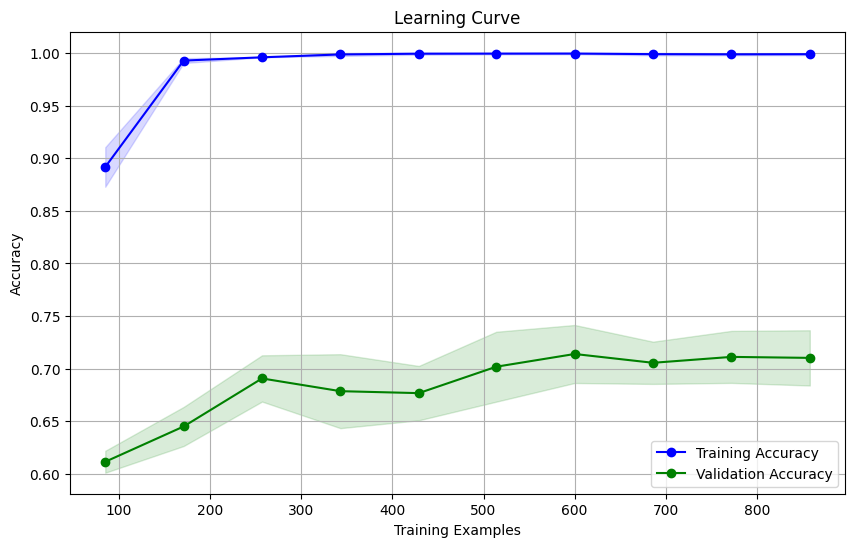

In [106]:
#  LightGBM classifier with the best hyperparameters
best_clf = lgb.LGBMClassifier(**best_params)




# Train classifier on the training data
best_clf.fit(X_train_best, y_train)

# Make predictions on the test data
y_pred = best_clf.predict(X_test_best)

# Calculate accuracy 
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Plot the learning curve
plot_learning_curve(best_clf, X_train_best, y_train)

In [107]:
feature_importances = best_clf.feature_importances_

#  store and display feature importances
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [126]:
importance_df

,Feature,Importance
13,total_protein,953
14,frequency,894
12,packed_cell_volume,814
0,rectal_temp,753
1,pulse,735
9,nasogastric_reflux_ph,644
19,encoded_combination,545
17,specific_code,500
18,shock_probability,491
5,pain,414


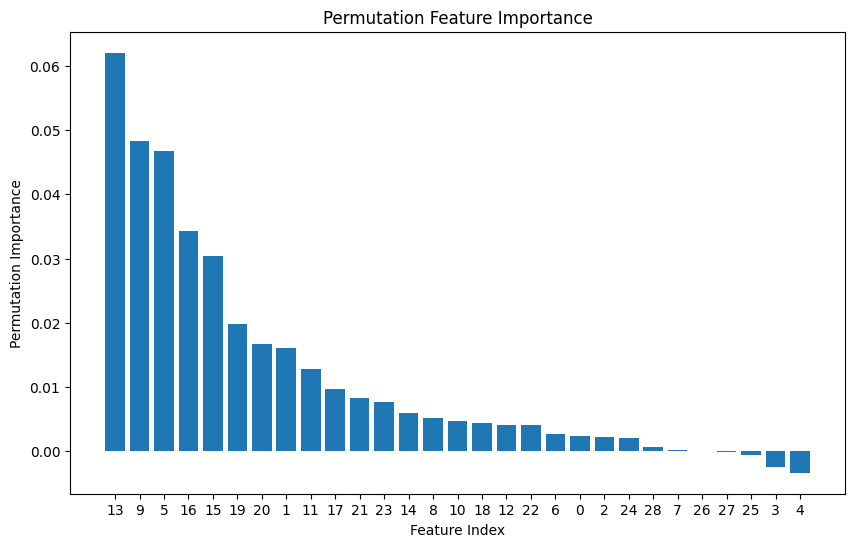

In [109]:
perm_importance = permutation_importance(best_clf, X_test, y_test, n_repeats=30, random_state=42)

# Visualize the feature importances
sorted_idx = perm_importance.importances_mean.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.bar(range(X_test.shape[1]), perm_importance.importances_mean[sorted_idx])
plt.xticks(range(X_test.shape[1]), sorted_idx)
plt.xlabel("Feature Index")
plt.ylabel("Permutation Importance")
plt.title("Permutation Feature Importance")
plt.show()

In [110]:
best_clf.fit(X ,y)
trialll = best_clf.predict(tt)

[LightGBM] [Warning] bagging_fraction is set=0.9869634529654318, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869634529654318


In [111]:
# final = best_clf.predict(X_test_scaled)

In [112]:
submission = pd.DataFrame({'id': test['id'], 'outcome': trialll})
submission['outcome'] = submission['outcome'].map({1:'died',0:'euthanized',2:'lived'})
submission.to_csv('submission.csv',index=False)

# XGB

In [113]:
# from hyperopt import fmin, tpe, hp
# from sklearn.model_selection import train_test_split, cross_val_score
# from mlxtend.feature_selection import PermutationImportance

In [114]:

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# space = {
#     'n_estimators': hp.choice('n_estimators', range(100, 1000)),
#     'max_depth': hp.choice('max_depth', range(1, 20)),
#     'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
#     'subsample': hp.uniform('subsample', 0.5, 1),
#     'min_child_weight': hp.choice('min_child_weight', range(1, 10)),
# }


# def objective(params):
#     model = xgb.XGBClassifier(
#         n_estimators=params['n_estimators'],
#         max_depth=params['max_depth'],
#         learning_rate=params['learning_rate'],
#         subsample=params['subsample'],
#         min_child_weight=params['min_child_weight'],
#         random_state=42,
#         tree_method='gpu_hist',  # Use GPU acceleration
#         gpu_id=0,  # Specify GPU device ID
#     )
#     score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
#     return -score  

# # Hyperparameter tuning with hyperopt
# best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, rstate=np.random.seed(42))


# model = xgb.XGBClassifier(
#     n_estimators=best['n_estimators'],
#     max_depth=best['max_depth'],
#     learning_rate=best['learning_rate'],
#     subsample=best['subsample'],
#     min_child_weight=best['min_child_weight'],
#     random_state=42,
#     tree_method='gpu_hist', 
#     gpu_id=0,  
# )


# model.fit(X_train, y_train)


# y_pred = model.predict(X_test)


# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy:", accuracy)


# train_sizes, train_scores, test_scores = learning_curve(
#     model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)

# plt.figure(figsize=(10, 6))
# plt.plot(train_sizes, train_mean, label='Training Accuracy', marker='o', linestyle='-')
# plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15)
# plt.plot(train_sizes, test_mean, label='Validation Accuracy', marker='o', linestyle='-')
# plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15)
# plt.xlabel('Number of Training Samples')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.grid()
# plt.title('Learning Curve')
# plt.show()


# plt.figure(figsize=(10, 6))
# xgb.plot_importance(model, importance_type='weight', xlabel='Weight')
# plt.title('Feature Importance (Weight)')
# plt.show()


# permuter = PermutationImportance(model, scoring='accuracy', n_iter=10, random_state=42)
# permuter.fit(X_test, y_test)
# feature_names = X_test.columns.tolist()
# perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
# # Get feature importances
# perm_importance_scores = perm_importance.importances_mean

# # Plot permutation feature importance
# plt.figure(figsize=(10, 6))
# plt.barh(feature_names, perm_importance_scores)
# plt.xlabel('Permutation Importance (Accuracy)')
# plt.title('Permutation Feature Importance')
# plt.show()

In [115]:
# resultss=model.predict(X_test_scaled)

In [116]:
# submission = pd.DataFrame({'id': test['id'], 'outcome': resultss})
# submission['outcome'] = submission['outcome'].map({1:'died',0:'euthanized',2:'lived'})
# submission.to_csv('xgbb.csv',index=False)

#  scikit learn HistGradientBoostingClassifier 

In [117]:
# from sklearn.experimental import enable_hist_gradient_boosting
# from sklearn.ensemble import HistGradientBoostingClassifier
# # Step 1: Import the necessary libraries

# # Step 2: Split your data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 3: Define the objective function for Optuna
# def objective(trial):
#     params = {
#         'max_iter': trial.suggest_categorical('max_iter', [100, 200, 300]),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
#         'max_depth': trial.suggest_categorical('max_depth', [3, 4, 5]),
#         'min_samples_leaf': trial.suggest_categorical('min_samples_leaf', [1, 2, 4]),
#     }
    
#     clf = HistGradientBoostingClassifier(random_state=42, **params)
#     clf.fit(X_train, y_train)
    
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
    
#     return accuracy

# # Step 4: Create and run the Optuna study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)  # You can adjust the number of trials

# # Step 5: Get the best hyperparameters and create the best model
# best_params = study.best_params
# best_model = HistGradientBoostingClassifier(random_state=42, **best_params)

# # Step 6: Fit the best model on the full training data
# best_model.fit(X_train, y_train)

# # Step 7: Calculate and print the accuracy on the test set
# y_pred = best_model.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Best Hyperparameters:", best_params)
# print("Accuracy on Test Set:", accuracy)

# # Step 8: Plot the learning curve
# def plot_learning_curve(estimator, X, y, title=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
#     plt.figure()
#     if title is not None:
#         plt.title(title)
#     if ylim is not None:
#         plt.ylim(*ylim)
#     plt.xlabel("Training examples")
#     plt.ylabel("Score")

#     train_sizes, train_scores, test_scores = learning_curve(
#         estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)

#     plt.grid()

#     plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                      train_scores_mean + train_scores_std, alpha=0.1,
#                      color="r")
#     plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
#     plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#              label="Training score")
#     plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#              label="Cross-validation score")

#     plt.legend(loc="best")
#     return plt

# plot_learning_curve(best_model, X_train, y_train, cv=3)
# plt.show()

In [118]:
# resultssss = best_model.predict(X_test_scaled)

In [119]:
# submission = pd.DataFrame({'id': test['id'], 'outcome': resultssss})
# submission['outcome'] = submission['outcome'].map({1:'died',0:'euthanized',2:'lived'})
# submission.to_csv('asd.csv',index=False)

# simple model  ensemble

In [120]:


# from sklearn.ensemble import (
#     RandomForestClassifier,
#     GradientBoostingClassifier,
#     AdaBoostClassifier,
#     VotingClassifier,
# )


# from sklearn.svm import SVC
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# import lightgbm as lgb




# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# def objective(trial):
 
#     n_estimators = trial.suggest_int("n_estimators", 50, 300)
#     max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
#     learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)


#     model = GradientBoostingClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         learning_rate=learning_rate,
#         random_state=42,
#     )

 
#     model.fit(X_train, y_train)

 
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)

#     return accuracy

# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100) 


# best_params = study.best_params
# print("Best Hyperparameters:", best_params)

# rf = RandomForestClassifier(n_estimators=best_params["n_estimators"], random_state=42)
# svc = SVC(probability=True)
# lr = LogisticRegression(max_iter=1000)
# dt = DecisionTreeClassifier(max_depth=best_params["max_depth"], random_state=42)
# lgbm = lgb.LGBMClassifier(
#     n_estimators=best_params["n_estimators"],
#     max_depth=best_params["max_depth"],
#     learning_rate=best_params["learning_rate"],
#     random_state=41,
# )


# ensemble = VotingClassifier(
#     estimators=[
#         ("rf", rf),
#         ("svc", svc),
#         ("lr", lr),
#         ("dt", dt),
#         ("lgbm", lgbm),
#     ],
#     voting="soft",  
# )

# ensemble.fit(X_train, y_train)
# ensemble_preds = ensemble.predict(X_test)
# ensemble_accuracy = accuracy_score(y_test, ensemble_preds)
# print("Ensemble Accuracy:", ensemble_accuracy)

In [121]:
# yz = ensemble.predict(X_test_scaled)

In [122]:
# submission = pd.DataFrame({'id': test['id'], 'outcome': yz})
# submission['outcome'] = submission['outcome'].map({1:'died',0:'euthanized',2:'lived'})
# submission.to_csv('asd3.csv',index=False)

# meta ensmeble

****this meta ensemble is working "just fine" but i will keep working on trying different models with different optimizations****

In [123]:
# from sklearn.ensemble import VotingClassifier, StackingClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.neural_network import MLPClassifier
# from xgboost import XGBClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC


# def objective(trial):
  
#     svc_c = trial.suggest_loguniform('svc_c', 1e-3, 1e3)
#     lr_C = trial.suggest_loguniform('lr_C', 1e-3, 1e3)
#     xgb_n_estimators = trial.suggest_int('xgb_n_estimators', 10, 500)
#     lgbm_num_leaves = trial.suggest_int('lgbm_num_leaves', 2, 50)

   
#     svc = SVC(C=svc_c, probability=True)
#     lr = LogisticRegression(C=lr_C)
#     xgb = XGBClassifier(n_estimators=xgb_n_estimators)
#     lgbm = LGBMClassifier(num_leaves=lgbm_num_leaves)

   
#     base_ensemble_1 = VotingClassifier(
#         estimators=[
#             ("svc", svc),
#             ("lr", lr),
#             ("xgb", xgb)
#         ],
#         voting="soft"
#     )

#     base_ensemble_2 = VotingClassifier(
#         estimators=[
#             ("lgbm", lgbm)
#         ],
#         voting="soft"
#     )


#     meta_ensemble = StackingClassifier(
#         estimators=[
#             ("base_ensemble_1", base_ensemble_1),
#             ("base_ensemble_2", base_ensemble_2),
          
#         ],
#         final_estimator=LogisticRegression()
#     )


#     meta_ensemble.fit(X_train, y_train)

  
#     meta_ensemble_preds = meta_ensemble.predict(X_val)

   
#     meta_ensemble_accuracy = accuracy_score(y_val, meta_ensemble_preds)

#     return meta_ensemble_accuracy


# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)  

# best_params = study.best_params
# print("Best Hyperparameters:", best_params)


# svc = SVC(C=best_params['svc_c'], probability=True)
# lr = LogisticRegression(C=best_params['lr_C'])
# xgb = XGBClassifier(n_estimators=best_params['xgb_n_estimators'])
# lgbm = LGBMClassifier(num_leaves=best_params['lgbm_num_leaves'])


# meta_ensemble.fit(X_train, y_train)


# meta_ensemble_preds = meta_ensemble.predict(X_test)


# meta_ensemble_accuracy = accuracy_score(y_test, meta_ensemble_preds)
# print("Meta-Ensemble Accuracy:", meta_ensemble_accuracy)

In [124]:
# me=meta_ensemble.predict(X_test_scaled)

In [125]:
# submission = pd.DataFrame({'id': test['id'], 'outcome': me})
# submission['outcome'] = submission['outcome'].map({1:'died',0:'euthanized',2:'lived'})
# submission.to_csv('meta6.csv',index=False)